# <span style="color:blue">Project X4.Часть вторая </span>

## Вступление <a class="anchor" id="id_0"></a> 

### Оглавление <a class="anchor" id="id_0a"></a> 

* [Вступление](#id_0)
  * [Оглавление](#id_0a)
  * [Библиотеки](#id_1a)
  * [Каталог загрузки](#id_1b)
  * [Функции](#id_1c)
* [Подготовка таблиц](#id_2)
  * [Очистка данных](#id_2a)
  * [Создание выборки кораблей по их назначению](#id_2b)
  * [Создание дополнительных колонок](#id_2c)
    * [Раса](#id_2c_1)
    * [Цвета рас](#id_2c_2)
    * [Создание колонки 'type' в таблице  ```shield_data```](#id_2c_3)
    * [Создание колонки 'type' в таблице ```engine_data```](#id_2c_4)
    * [Создание колонки "aggregate_defence"](#id_2c_5)
    * [Создание колонки  'max_speed'](#id_2c_6)
  * [Диаграммы](#id_3)

Первая часть посвящена получению данных из файлов игры и находится в файле "X4 datamining_ru.ipynb".  
Во второй части на базе полученных таблиц рассчитаны несколько аггрегатных показателей (суммарная защита, максимальная скорость), а также построено несколько диаграмм. Это сделано только для кораблей доступных игроку (дроны, ракеты, полиция, ксенонские и хаакские корабли исключены для расчета).
В конце создана новая таблица, объединяющая в себе параметры из таблицы ship_data с новыми параметрами.  


### Библиотеки <a class="anchor" id="id_1"></a> 

In [86]:
import pandas as pd
import os
import re
from bs4 import BeautifulSoup
import lxml
import matplotlib.pyplot as plt
import random
pd.set_option('display.max_columns', None)
#pd.set_option('max_colwidth', 300)
import warnings
warnings.filterwarnings('ignore')

### Загрузочный каталог <a class="anchor" id="id_1b"></a> 

In [87]:
load_folder = r'H:\Steam\X4\SavedTables'

### Необходимые функции <a class="anchor" id="id_1c"></a> 

In [88]:
#функция для выравнивания списков
def flatten(l):
    return [item for sublist in l for item in sublist]

In [89]:
# Функция для вывода пропущенных значений в датафрейме, просто вызовите ее, указав нужный датафрейм в параметрах
def missing_values_tab(df):
    #Подсчет количества пропущенных значений
    mis_val = df.isnull().sum()
    #Подсчет доли пропущенных значений в колонке в процентах
    mis_val_percent = round(100 * df.isnull().sum() / len(df),2)
    #Объединяем две созданных колонки в один датафрейм с параметром axis=1, чтобы добавить их справа-слева
    mv_table = pd.concat([mis_val, mis_val_percent], axis=1)  
    #Переименование колонок
    mv_table = mv_table.rename(columns = {0 : 'Пропущенные значения', 1 : '% от всех значений'})
    #Создаем колонку с типом данных 
    mv_table['Тип данных'] = df.dtypes
    mv_table = mv_table[mv_table.iloc[:,1]!=0].sort_values(by='Пропущенные значения',ascending=False)
    print ("Ваш датафрейм содержит " + str(df.shape[1]) + " колонок и " + str(df.shape[0]) + " строк.\n")
    print("Он имеет  " + str(mv_table.shape[0]) +" колонок с пропущенными значениями.")    
    return display(mv_table) 

In [90]:
# Функция для определения типа щита на основе имени
def calculate_type(data):
    if re.match('^\w+\s+(L)+\s', data):
        return "L"
    if re.match('^\w+\s+(XL)+\s', data):
        return "XL"
    if re.match('^\w+\s+(M)+\s', data):
        return "M"
    if re.match('^\w+\s+(S)+\s', data):
        return "S"  

## Подготовка таблиц <a class="anchor" id="id_2"></a> 

### Очистка данных <a class="anchor" id="id_2a"></a> 

Загрузка первых пяти записей из данных:

In [91]:
#Load file with ship data
ship_data = pd.read_csv(load_folder+r'\raw_X4data.csv')
display(ship_data.head())
#load file with shield data
shield_data = pd.read_csv(load_folder+r'\shields_X4data.csv')
display(shield_data.head())
#load engine data
engine_data = pd.read_csv(load_folder+r'\engines_X4data.csv')
display(engine_data.head())

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots
0,ship_arg_l_destroyer_01,ship_arg_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,93000,2,fight,44,196.016,96.271,96.271,77.016,99.004,396.016,73.005,73.005,106.203,106.203,106.203,destroyer,Behemoth Vanguard,11002,3,9,2,8,3
1,ship_arg_l_destroyer_01,ship_arg_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,111000,2,fight,36,235.220,103.378,103.378,82.702,108.805,435.220,87.605,87.605,114.044,114.044,114.044,destroyer,Behemoth Sentinel,11003,3,9,2,8,3
2,ship_arg_l_miner_liquid_01,ship_arg_l_miner_liquid_01_a_macro,ship_l,800,4000,30,10,26000,1,mine,46,205.270,133.749,133.749,106.999,56.738,324.216,126.666,126.666,140.897,140.897,140.897,largeminer,Magnetar Gas Vanguard,11104,2,7,0,6,2
3,ship_arg_l_miner_liquid_01,ship_arg_l_miner_liquid_01_b_macro,ship_l,800,4000,30,10,32000,1,mine,38,246.324,147.778,147.778,118.223,62.485,357.059,151.999,151.999,155.677,155.677,155.677,largeminer,Magnetar Gas Sentinel,11105,2,7,0,6,2
4,ship_arg_l_miner_solid_01,ship_arg_l_miner_solid_01_a_macro,ship_l,800,4000,30,10,26000,1,mine,46,204.245,132.733,132.733,106.186,56.594,323.396,127.239,127.239,140.528,140.528,140.528,largeminer,Magnetar Mineral Vanguard,11102,2,9,1,6,2


,name,filename,page_id,shield_id,maker,version,shield_value,recharge_rate,recharge_delay,hull
0,ARG L Shield Generator Mk1,shield_arg_l_standard_01_mk1_macro.xml,20106,3004,argon,1,38844,173,0.0,2000
1,ARG L Shield Generator Mk2,shield_arg_l_standard_01_mk2_macro.xml,20106,3044,argon,2,46282,268,0.0,2000
2,ARG M Shield Generator Mk1,shield_arg_m_standard_02_mk1_macro.xml,20106,2004,argon,1,5147,26,0.5,500
3,ARG M Shield Generator Mk2,shield_arg_m_standard_02_mk2_macro.xml,20106,2044,argon,2,6133,41,0.5,500
4,ARG S Shield Generator Mk1,shield_arg_s_standard_01_mk1_macro.xml,20106,1004,argon,1,827,82,12.1,0


,name,filename,class,page_id,engine_id,maker,version,boost_duration,boost_thrust,boost_attack,boost_release,travel_charge,travel_thrust,travel_attack,travel_release,thrust_forward,thrust_reverse
0,ARG L All-round Engine Mk1,engine_arg_l_allround_01_mk1_macro.xml,engine,20107,3004,argon,1,29,2.0,10.00,1.0,20,31,75.0,22.5,4206,4627
1,ARG L Travel Engine Mk1,engine_arg_l_travel_01_mk1_macro.xml,engine,20107,3044,argon,1,26,2.0,10.00,1.0,20,33,85.0,37.5,4006,3605
2,ARG M All-round Engine Mk1,engine_arg_m_allround_01_mk1_macro.xml,engine,20107,2004,argon,1,7,8.0,0.25,1.0,1,9,30.0,20.0,1002,952
3,ARG M All-round Engine Mk2,engine_arg_m_allround_01_mk2_macro.xml,engine,20107,2044,argon,2,7,8.0,0.25,1.0,1,9,30.0,20.0,1212,1228
4,ARG M All-round Engine Mk3,engine_arg_m_allround_01_mk3_macro.xml,engine,20107,2084,argon,3,7,8.0,0.25,1.0,1,9,30.0,20.0,1353,1413


Вывод информации о пропусках в таблицах:

In [92]:
missing_values_tab(ship_data)
ship_data.info()

Ваш датафрейм содержит 30 колонок и 321 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 321 entries, 0 to 320
Data columns (total 30 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   component               321 non-null    object 
 1   filename                321 non-null    object 
 2   ship_class              321 non-null    object 
 3   explosiondamage_shield  321 non-null    int64  
 4   explosiondamage_value   321 non-null    int64  
 5   storage_missile         321 non-null    int64  
 6   storage_unit            321 non-null    int64  
 7   hull                    321 non-null    int64  
 8   secrecy_level           321 non-null    int64  
 9   purpose                 321 non-null    object 
 10  people_capacity         321 non-null    int64  
 11  ship_mass               321 non-null    float64
 12  inertia_pitch           321 non-null    float64
 13  inertia_roll            321 non-null    float64
 14  inertia_yaw             321 non-null    fl

In [93]:
missing_values_tab(shield_data)
shield_data.info()

Ваш датафрейм содержит 10 колонок и 65 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65 entries, 0 to 64
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            65 non-null     object 
 1   filename        65 non-null     object 
 2   page_id         65 non-null     int64  
 3   shield_id       65 non-null     int64  
 4   maker           65 non-null     object 
 5   version         65 non-null     int64  
 6   shield_value    65 non-null     int64  
 7   recharge_rate   65 non-null     int64  
 8   recharge_delay  65 non-null     float64
 9   hull            65 non-null     int64  
dtypes: float64(1), int64(6), object(3)
memory usage: 5.2+ KB


### Работа с пропусками

In [94]:
display(ship_data[ship_data.isna().any(axis =1)])

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots


Пропусков в данных нет. Записи с ненужными категориями можно удалить. 

Создание списка ненужных категорий:


In [95]:
ship_data['ship_type'].unique()


array(['destroyer', 'largeminer', 'freighter', 'gunboat', 'scavenger',
       'frigate', 'miner', 'transporter', 'tug', 'heavyfighter',
       'corvette', 'fighter', 'scout', 'courier', 'smalldrone',
       'lasertower', 'builder', 'carrier', 'resupplier', 'battleship',
       'personalvehicle', 'police', 'unknown', 'xsdrone', 'distressdrone',
       'escapepod', 'compactor'], dtype=object)

In [96]:
exclude_ship_types = ['personalvehicle','lasertower','escapepod','unknown','smalldrone', 'police', 'distressdrone', 'xsdrone']

Дроны тоже можно исключить, boarding pod тоже.

In [97]:
exclude_names = ship_data[(ship_data['name'].str.contains('Drone')) | 
          (ship_data['name']=='Boarding Pod')]['name'].unique()

Вывод информации о корабле с именем "Unknown ship"

In [98]:
display(ship_data[ship_data['name'].str.contains('Unknown')])

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots
158,ship_tfm_xl_carrier_01,ship_tfm_xl_carrier_01_a_macro,ship_xl,1500,7500,0,0,735000,3,fight,0,1874.085,1397.262,1397.262,1117.81,454.817,1819.268,187.409,187.409,1074.817,1074.817,1074.817,carrier,Unknown Ship,79101,1,0,0,0,1


Такого корабля в распоряжении игрока нет, поэтому строку можно удалить.

Создание очищенной таблицы:

In [99]:
ship_data = ship_data[~ship_data['ship_type'].isin(exclude_ship_types)]
ship_data = ship_data[~ship_data['name'].isin(exclude_names)]

Вывод новой информации о пропусках:

In [100]:
missing_values_tab(ship_data)

Ваш датафрейм содержит 30 колонок и 235 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


### Работа с категориальными данными

Удаление возможных пробелов в названиях кораблей и щитов:

In [101]:
ship_data['name'] = ship_data['name'].str.strip()
shield_data['name'] = shield_data['name'].str.strip()

Вывод информации о типах кораблей:

In [102]:
ship_data['ship_type'].unique()

array(['destroyer', 'largeminer', 'freighter', 'gunboat', 'scavenger',
       'frigate', 'miner', 'transporter', 'tug', 'heavyfighter',
       'corvette', 'fighter', 'scout', 'courier', 'builder', 'carrier',
       'resupplier', 'battleship', 'compactor'], dtype=object)

In [103]:
ship_data['ship_class'].unique()

array(['ship_l', 'ship_m', 'ship_s', 'ship_xl'], dtype=object)

In [104]:
shield_data['name'].unique()

array(['ARG L Shield Generator Mk1', 'ARG L Shield Generator Mk2',
       'ARG M Shield Generator Mk1', 'ARG M Shield Generator Mk2',
       'ARG S Shield Generator Mk1', 'ARG S Shield Generator Mk2',
       'ARG S Shield Generator Mk3', 'ARG XL Shield Generator Mk1',
       'KHA M Shield Generator Mk1', 'KHA S Shield Generator Mk1',
       'PAR L Shield Generator Mk1', 'PAR L Shield Generator Mk2',
       'PAR M Shield Generator Mk1', 'PAR M Shield Generator Mk2',
       'PAR S Shield Generator Mk1', 'PAR S Shield Generator Mk2',
       'PAR S Shield Generator Mk3', 'PAR XL Shield Generator Mk1',
       'TEL L Shield Generator Mk1', 'TEL L Shield Generator Mk2',
       'TEL M Shield Generator Mk1', 'TEL M Shield Generator Mk2',
       'TEL S Shield Generator Mk1', 'TEL S Shield Generator Mk2',
       'TEL S Shield Generator Mk3', 'TEL XL Shield Generator Mk1',
       'XEN L Shield Generator Mk1', 'XEN L Shield Generator Mk2',
       'XEN M Shield Generator Mk1', 'XEN M Shield Generato

Поиск дубликатов


In [105]:
duplicated_names = ship_data.groupby('name')['name'].value_counts().sort_values(ascending = False)
print(duplicated_names)

name
Eclipse Vanguard           2
Barbarossa                 2
Thresher                   2
Tuatara                    2
Plutus Mineral Sentinel    1
                          ..
Hermes Sentinel            1
Hermes Vanguard            1
Heron Sentinel             1
Heron Vanguard             1
Zeus Vanguard              1
Name: count, Length: 231, dtype: int64


In [106]:
display(ship_data[ship_data['name'].str.contains('Eclipse')])

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots
92,ship_arg_s_heavyfighter_01,ship_arg_s_heavyfighter_01_a_macro,ship_s,0,0,50,0,4400,2,fight,3,9.304,2.480,2.480,1.984,5.155,21.456,3.514,3.514,3.845,3.845,3.845,heavyfighter,Eclipse Vanguard,10402,2,0,0,0,2
93,ship_arg_s_heavyfighter_01,ship_arg_s_heavyfighter_01_b_macro,ship_s,0,0,50,0,5300,2,fight,2,11.165,2.856,2.856,2.284,5.539,24.248,4.217,4.217,4.427,4.427,4.427,heavyfighter,Eclipse Sentinel,10403,2,0,0,0,2
94,ship_arg_s_heavyfighter_02,ship_arg_s_heavyfighter_02_a_macro,ship_s,0,0,20,0,4000,2,fight,3,8.406,2.077,2.077,1.662,4.970,20.108,3.883,3.883,3.564,3.564,3.564,heavyfighter,Eclipse Vanguard,10402,2,0,0,0,2


Eclipse Vanguard - правильная строка 94, строку 92 - удалить

In [107]:
display(ship_data[ship_data['name'].str.contains('Barbarossa')])

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots
238,ship_pir_l_scavenger_01,ship_pir_l_scavenger_01_a_macro,ship_l,800,4000,160,10,114000,1,fight,126,243.18,130.042,130.042,104.034,86.42,345.68,126.805,126.805,115.636,115.636,115.636,scavenger,Barbarossa,81501,1,20,4,10,4
239,ship_pir_l_scavenger_01,ship_pir_l_scavenger_01_a_storyhighcapacity_macro,ship_l,800,4000,160,10,114000,1,fight,126,243.18,130.042,130.042,104.034,86.42,345.68,126.805,126.805,115.636,115.636,115.636,scavenger,Barbarossa,81501,1,20,4,10,4


Barbarossa - удалить строку с индексом 239

In [108]:
display(ship_data[ship_data['name'].str.contains('Thresher')])
display(ship_data[ship_data['name'].str.contains('Tuatara')])

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots
215,ship_bor_m_gunboat_01,ship_bor_m_gunboat_01_a_macro,ship_m,500,2500,88,0,10900,1,fight,8,32.713,6.827,6.827,5.461,4.405,17.619,12.611,12.611,10.678,10.678,10.678,gunboat,Thresher,51101,2,0,0,8,2
216,ship_bor_m_liquid_miner_01,ship_bor_m_liquid_miner_01_a_macro,ship_m,100,500,20,0,5000,2,mine,10,30.000,8.000,10.000,8.000,4.000,22.000,25.000,10.000,16.000,30.000,16.000,miner,Thresher,0,0,0,0,0,0


,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots
297,ship_spl_s_miner_solid_01,ship_spl_s_miner_solid_01_a_macro,ship_s,0,0,10,0,1200,1,mine,2,9.209,3.748,3.748,2.998,4.002,19.656,3.561,3.561,3.815,3.815,3.815,miner,Tuatara Mineral,42104,1,0,0,0,3
299,ship_spl_s_trans_container_01,ship_spl_s_trans_container_01_a_macro,ship_s,0,0,10,0,2300,1,trade,4,17.257,6.473,6.473,5.179,5.109,21.807,6.061,6.061,6.330,6.330,6.330,courier,Tuatara,42101,1,0,0,0,3
300,ship_spl_s_trans_container_01,ship_spl_s_trans_container_01_plot_01_macro,ship_s,0,0,10,0,2300,1,trade,4,17.200,6.400,6.400,5.100,5.100,21.800,6.000,6.000,6.300,6.300,6.300,courier,Tuatara,42101,1,0,0,0,3


Thresher - удалить строку с индексом 216.  
Tuatara - удалить строку с индексом 300. 
Также удалю строку с индексом 158, где находится корабль с именем "Unknown ship".  
Подобные дубли вероятно образовались из-за того, что эти корабли участвовали в игровых миссиях и разработчики сделали их дубликаты в силу каких-то причин.

In [109]:
ship_data = ship_data.loc[ship_data.index.drop([92, 239, 216, 300, 158])]

Сброс индекса и создание нового:

In [110]:
ship_data = ship_data.reset_index(drop = True)

In [111]:
display(ship_data.duplicated().sum())

0

Проверка дубликатов в таблице ```shield_data```

In [112]:
duplicated_names = shield_data.groupby('name')['name'].value_counts().sort_values(ascending = False)
print(duplicated_names)

name
ARG L Shield Generator Mk1     1
SPL M Shield Generator Mk1     1
SPL S Shield Generator Mk1     1
SPL S Shield Generator Mk2     1
SPL S Shield Generator Mk3     1
                              ..
PAR S Shield Generator Mk1     1
PAR S Shield Generator Mk2     1
PAR S Shield Generator Mk3     1
PAR XL Shield Generator Mk1    1
XEN XL Shield Generator Mk1    1
Name: count, Length: 65, dtype: int64


Дубликатов нет

### Создание выборки кораблей по назначению <a class="anchor" id="id_2b"></a>

In [113]:
purposes = ['fight', 'mine', 'trade', 'dismantling', 'salvage' ,'build', 'auxiliary']
fight_ships = ship_data[ship_data["purpose"]=="fight"]
mine_ships = ship_data[ship_data["purpose"]=="mine"]
trade_ships = ship_data[ship_data["purpose"]=="trade"]
builders = ship_data[ship_data["purpose"]=="build"]
auxiliary_ships = ship_data[ship_data["purpose"]=="auxiliary"]
dismantling_ships = ship_data[ship_data["purpose"]=='dismantling']
salvage_ships = ship_data[ship_data["purpose"]=='salvage']
dfs_list = [fight_ships, mine_ships, trade_ships, builders, auxiliary_ships, dismantling_ships, salvage_ships]
all_ships = pd.DataFrame()
for df in dfs_list:
    all_ships = pd.concat([all_ships, df], axis = 0)

#### Debugging info

In [114]:
#Проверка подозрительных записей
display(all_ships.loc[all_ships['name'].str.contains('Orca')])


,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots
169,ship_bor_xl_resupplier_01,ship_bor_xl_resupplier_01_a_macro,ship_xl,1200,6000,268,100,174000,1,auxiliary,154,1569.585,629.542,629.542,503.633,344.677,1378.709,750.951,750.951,750.584,750.584,750.584,resupplier,Orca,50401,3,10,0,12,3


### Создание дополнительных колонок <a class="anchor" id="id_2c"></a> 

#### Создание колонки с расами <a class="anchor" id="id_2c_1"></a>

In [115]:
def calculate_race(data):
    if re.match('\D+_tel_\D+', data):
        return "teladi"
    if re.match('\D+_arg_\D+', data):
        return "argon"
    if re.match('\D+_par_\D+', data):
        return "paranid"
    if re.match('\D+_ter_\D+', data):
        return "terran"
    if re.match('\D+_spl_\D+', data):
        return "split"
    if re.match('\D+_pir_\D+', data):
        return "pirate"
    if re.match('\D+_xen_\D+', data):
        return "xenons"
    if re.match('\D+_atf_\D+', data):
        return "terran"
    if re.match('\D+_gen_\D+', data):
        return "game_npc"
    if re.match('\D+_kha_\D+', data):
        return "khaak"
    if re.match('\D+_yak_\D+', data):
        return "yaki"
    if re.match('\D+_tfm_\D+', data):
        return "TFM"
    if re.match('\D+_bor_\D+', data):
        return "boron"

In [116]:
all_ships['race'] = all_ships['filename'].apply(calculate_race)

In [117]:
display(all_ships.head())

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots,race
0,ship_arg_l_destroyer_01,ship_arg_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,93000,2,fight,44,196.016,96.271,96.271,77.016,99.004,396.016,73.005,73.005,106.203,106.203,106.203,destroyer,Behemoth Vanguard,11002,3,9,2,8,3,argon
1,ship_arg_l_destroyer_01,ship_arg_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,111000,2,fight,36,235.220,103.378,103.378,82.702,108.805,435.220,87.605,87.605,114.044,114.044,114.044,destroyer,Behemoth Sentinel,11003,3,9,2,8,3,argon
16,ship_par_l_destroyer_01,ship_par_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,99000,3,fight,47,209.751,105.680,105.680,84.544,76.828,307.313,68.897,68.897,108.950,108.950,108.950,destroyer,Odysseus Vanguard,30702,2,15,4,12,3,paranid
17,ship_par_l_destroyer_01,ship_par_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,119000,3,fight,39,251.701,113.818,113.818,91.055,84.694,338.776,82.676,82.676,117.340,117.340,117.340,destroyer,Odysseus Sentinel,30703,2,15,4,12,3,paranid
18,ship_par_l_destroyer_02,ship_par_l_destroyer_02_a_macro,ship_l,1000,5000,160,10,128000,3,fight,60,326.351,199.622,199.622,159.698,69.084,394.763,83.274,83.274,132.270,132.270,132.270,destroyer,Odysseus E,30704,2,17,4,12,3,paranid


In [118]:
display(all_ships.loc[all_ships.isna().any(axis = 1)])

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots,race


#### Создание цветовой кодировки: <a class="anchor" id="id_2c_2"></a> 


argon - темно-синий;   
teladi - грязно- желтый;    
paranid - фиолетовый;    
split - Оранжевый;  
boron - светло-синий;  
terran - серый;  
yaki - темно - розовый;  
xenons - красный;  
khaak  светло-розовый;
game_npc - светло-зеленый;    
pirat - бежевый.

In [119]:
faction_colors = {  
                  'argon':'#2333c2',
                  'teladi':'#bfde7c',                 
                  'yaki':'#6d2580',
                  'paranid':'#ae10de',
                  'split':'#de6910',
                  'boron':'#567edb',
                  'xenons':'#cf173b',
                  'khaak':'#d085ed',
                  'terran':'#808c8c',
                  'pirate':'#e8d5e7',
                  'game_npc':'#8fe67e'
                  }

Создание цветовой колонки:

In [120]:
all_ships = all_ships.assign(
    color = lambda row: row['race'].map (faction_colors )
    )

In [121]:
all_ships.head()

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots,race,color
0,ship_arg_l_destroyer_01,ship_arg_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,93000,2,fight,44,196.016,96.271,96.271,77.016,99.004,396.016,73.005,73.005,106.203,106.203,106.203,destroyer,Behemoth Vanguard,11002,3,9,2,8,3,argon,#2333c2
1,ship_arg_l_destroyer_01,ship_arg_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,111000,2,fight,36,235.220,103.378,103.378,82.702,108.805,435.220,87.605,87.605,114.044,114.044,114.044,destroyer,Behemoth Sentinel,11003,3,9,2,8,3,argon,#2333c2
16,ship_par_l_destroyer_01,ship_par_l_destroyer_01_a_macro,ship_l,1000,5000,160,10,99000,3,fight,47,209.751,105.680,105.680,84.544,76.828,307.313,68.897,68.897,108.950,108.950,108.950,destroyer,Odysseus Vanguard,30702,2,15,4,12,3,paranid,#ae10de
17,ship_par_l_destroyer_01,ship_par_l_destroyer_01_b_macro,ship_l,1000,5000,160,10,119000,3,fight,39,251.701,113.818,113.818,91.055,84.694,338.776,82.676,82.676,117.340,117.340,117.340,destroyer,Odysseus Sentinel,30703,2,15,4,12,3,paranid,#ae10de
18,ship_par_l_destroyer_02,ship_par_l_destroyer_02_a_macro,ship_l,1000,5000,160,10,128000,3,fight,60,326.351,199.622,199.622,159.698,69.084,394.763,83.274,83.274,132.270,132.270,132.270,destroyer,Odysseus E,30704,2,17,4,12,3,paranid,#ae10de


#### Создание колонки 'type' в таблице ```shield_data``` <a class="anchor" id="id_2c_3"></a> 

In [122]:
#Создание колонки
shield_data['type'] = shield_data['name'].apply(calculate_type)

In [123]:
display(shield_data[['name', 'type']].tail(10))

,name,type
55,TER L Shield Generator Mk2,L
56,TER L Shield Generator Mk3,L
57,TER M Shield Generator Mk1,M
58,TER M Shield Generator Mk2,M
59,TER M Shield Generator Mk3,M
60,TER S Shield Generator Mk1,S
61,TER S Shield Generator Mk2,S
62,TER S Shield Generator Mk3,S
63,TER XL Shield Generator Mk1,XL
64,TER XL Shield Generator Mk2,XL


In [124]:
# Проверка, не образовались ли новые пропуски
missing_values_tab(all_ships)
missing_values_tab(shield_data)

Ваш датафрейм содержит 32 колонок и 230 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


Ваш датафрейм содержит 11 колонок и 65 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


#### Создание колонки type для таблицы engine_data <a class="anchor" id="id_2c_4"></a> 

In [125]:
engine_data['type'] = engine_data['name'].apply(calculate_type)
display(engine_data[['name','type']].tail(10))

,name,type
120,TER S All-round Engine Mk2,S
121,TER S All-round Engine Mk3,S
122,TER S Combat Engine Mk1,S
123,TER S Combat Engine Mk2,S
124,TER S Combat Engine Mk3,S
125,TER S Travel Engine Mk1,S
126,TER S Travel Engine Mk2,S
127,TER S Travel Engine Mk3,S
128,TER XL All-round Engine Mk1,XL
129,TER XL Travel Engine Mk1,XL


#### Создание колонки "aggregate_defence" <a class="anchor" id="id_2c_5"></a> 

Создание выборки кораблей, доступных для игрока:

In [126]:
exclude_race = ['xenons','khaak','game_npc']
race_list  = [x for x in all_ships['race'].unique() if x not in exclude_race]
accesible_ships = all_ships[all_ships['race'].isin(race_list)]

The column is a sum of 'hull'  and multiplication of 'primary_shield_slots'*'shield_value' of the corresponding shield type
For boron ships will be used only boron shields, for other ships - the shield with the max shield value for that ship class (L shields for L ships, M shields for M ships etc).  
Display shield data for each type of shield: 

In [127]:
for type in shield_data['type'].unique():
    print('Shields of type {}'.format(type))
    display(shield_data[shield_data['type']==type].sort_values('shield_value', ascending = False).head())
    # Assign variables for calculation of aggregate defence value
    if type == 'L':
        shield_value_l = shield_data[(shield_data['type']==type) & (shield_data['maker']!='boron')]['shield_value'].max()
        boron_shield_value_l = shield_data[(shield_data['type']==type) & (shield_data['maker']=='boron')]['shield_value'].max()
        print(f'{type}: ',shield_value_l,' For borons: ', boron_shield_value_l)
    if type == 'XL':
        shield_value_xl = shield_data[(shield_data['type']==type) & (shield_data['maker']!='boron')]['shield_value'].max()
        boron_shield_value_xl = shield_data[(shield_data['type']==type) & (shield_data['maker']=='boron')]['shield_value'].max()
        print(f'{type}: ',shield_value_xl,' For borons: ', boron_shield_value_xl)
    if type == 'M':
        shield_value_m = (
            shield_data[(shield_data['type']==type) 
                        & (shield_data['maker']!='boron')
                        # Exclude Astrid's shield because it is  a unique ship 
                        & (shield_data['name'].str.contains('Astrid')==False)]['shield_value'].max()
            )
        boron_shield_value_m = shield_data[(shield_data['type']==type) & (shield_data['maker']=='boron')]['shield_value'].max()
        print(f'{type}: ',shield_value_m,' For borons: ', boron_shield_value_m)
    if type == 'S':
        shield_value_s = shield_data[(shield_data['type']==type) & (shield_data['maker']!='boron')]['shield_value'].max()
        boron_shield_value_s = shield_data[(shield_data['type']==type) & (shield_data['maker']=='boron')]['shield_value'].max()
        print(f'{type}: ',shield_value_s,' For borons: ', boron_shield_value_s)

Shields of type L


,name,filename,page_id,shield_id,maker,version,shield_value,recharge_rate,recharge_delay,hull,type
56,TER L Shield Generator Mk3,shield_ter_l_standard_01_mk3_macro.xml,20106,3124,terran,3,69424,424,0.0,2000,L
45,BOR L Shield Generator Mk3,shield_bor_l_standard_01_mk3_macro.xml,20106,3154,boron,3,68399,422,0.0,2000,L
19,TEL L Shield Generator Mk2,shield_tel_l_standard_01_mk2_macro.xml,20106,3064,teladi,2,50911,257,0.0,2000,L
55,TER L Shield Generator Mk2,shield_ter_l_standard_01_mk2_macro.xml,20106,3114,terran,2,48597,247,0.0,2000,L
44,BOR L Shield Generator Mk2,shield_bor_l_standard_01_mk2_macro.xml,20106,3144,boron,2,47879,246,0.0,2000,L


L:  69424  For borons:  68399
Shields of type M


,name,filename,page_id,shield_id,maker,version,shield_value,recharge_rate,recharge_delay,hull,type
41,Astrid M Shield Generator,shield_gen_m_yacht_01_mk1_macro.xml,20106,9004,argon,1,50911,709,0.28,0,M
59,TER M Shield Generator Mk3,shield_ter_m_standard_02_mk3_macro.xml,20106,2134,terran,3,9199,77,0.47,500,M
48,BOR M Shield Generator Mk3,shield_bor_m_standard_02_mk3_macro.xml,20106,2164,boron,3,8877,68,0.33,500,M
21,TEL M Shield Generator Mk2,shield_tel_m_standard_02_mk2_macro.xml,20106,2064,teladi,2,6746,39,0.57,500,M
58,TER M Shield Generator Mk2,shield_ter_m_standard_02_mk2_macro.xml,20106,2124,terran,2,6439,45,0.47,500,M


M:  9199  For borons:  8877
Shields of type S


,name,filename,page_id,shield_id,maker,version,shield_value,recharge_rate,recharge_delay,hull,type
24,TEL S Shield Generator Mk3,shield_tel_s_standard_01_mk3_macro.xml,20106,1104,teladi,3,1552,210,13.9,0,S
62,TER S Shield Generator Mk3,shield_ter_s_standard_01_mk3_macro.xml,20106,1184,terran,3,1482,242,11.5,0,S
51,BOR S Shield Generator Mk3,shield_bor_s_standard_01_mk3_macro.xml,20106,1214,boron,3,1455,229,8.0,0,S
6,ARG S Shield Generator Mk3,shield_arg_s_standard_01_mk3_macro.xml,20106,1084,argon,3,1411,219,12.1,0,S
16,PAR S Shield Generator Mk3,shield_par_s_standard_01_mk3_macro.xml,20106,1094,paranid,3,1270,232,10.2,0,S


S:  1552  For borons:  1455
Shields of type XL


,name,filename,page_id,shield_id,maker,version,shield_value,recharge_rate,recharge_delay,hull,type
64,TER XL Shield Generator Mk2,shield_ter_xl_standard_01_mk2_macro.xml,20106,4064,terran,2,161988,842,0.0,8000,XL
53,BOR XL Shield Generator Mk2,shield_bor_xl_standard_01_mk2_macro.xml,20106,4084,boron,2,159937,670,0.0,6000,XL
42,Erlking XL Shield Generator,shield_pir_xl_battleship_01_standard_01_mk1_ma...,20106,9014,argon,1,158600,662,0.0,8100,XL
25,TEL XL Shield Generator Mk1,shield_tel_xl_standard_01_mk1_macro.xml,20106,4024,teladi,1,142429,470,0.0,6000,XL
63,TER XL Shield Generator Mk1,shield_ter_xl_standard_01_mk1_macro.xml,20106,4054,terran,1,135955,544,0.0,6000,XL


XL:  161988  For borons:  159937


Вычисление значения параметра на основе класса кораблей:

In [128]:
# for xl ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_xl'),'aggregate_defence']=accesible_ships['primary_shield_slots']*shield_value_xl + accesible_ships['hull']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_xl'),'aggregate_defence']=accesible_ships['primary_shield_slots']*boron_shield_value_xl + accesible_ships['hull']
  
# for l ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_l'),'aggregate_defence']=accesible_ships['primary_shield_slots']*shield_value_l + accesible_ships['hull']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_l'),'aggregate_defence']=accesible_ships['primary_shield_slots']*boron_shield_value_l + accesible_ships['hull']
# for m ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_m'),'aggregate_defence']=accesible_ships['primary_shield_slots']*shield_value_m + accesible_ships['hull']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_m'),'aggregate_defence']=accesible_ships['primary_shield_slots']*boron_shield_value_m + accesible_ships['hull']
# for s ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_s'),'aggregate_defence']=accesible_ships['primary_shield_slots']*shield_value_s + accesible_ships['hull']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_s'),'aggregate_defence']=accesible_ships['primary_shield_slots']*boron_shield_value_s + accesible_ships['hull']
# values for Erlking and Astrid with their unique shields
accesible_ships.loc[
            accesible_ships['name'].str.contains('Astrid'),'aggregate_defence']=accesible_ships['primary_shield_slots']*50911 + accesible_ships['hull']
accesible_ships.loc[
            accesible_ships['name'].str.contains('Erlking'),'aggregate_defence']=accesible_ships['primary_shield_slots']*158600 + accesible_ships['hull']
        
#Изменение формата с float на integer
accesible_ships['aggregate_defence'] = accesible_ships['aggregate_defence'].astype(int)
display(accesible_ships[['name','ship_class','hull','primary_shield_slots','aggregate_defence']])

,name,ship_class,hull,primary_shield_slots,aggregate_defence
0,Behemoth Vanguard,ship_l,93000,3,301272
1,Behemoth Sentinel,ship_l,111000,3,319272
16,Odysseus Vanguard,ship_l,99000,2,237848
17,Odysseus Sentinel,ship_l,119000,2,257848
18,Odysseus E,ship_l,128000,2,266848
...,...,...,...,...,...
147,Stork Sentinel,ship_xl,126000,2,449976
169,Orca,ship_xl,174000,3,653811
206,Honshu,ship_xl,157000,1,318988
229,Monitor,ship_xl,160000,1,321988


#### Создание колонки max_speed <a class="anchor" id="id_2c_6"></a> 

In [129]:
for type in engine_data['type'].unique():
    print('Engines of type {}'.format(type))
    display(engine_data[engine_data['type']==type][['name','thrust_forward']].sort_values('thrust_forward', ascending = False).head(10))
   

Engines of type L


,name,thrust_forward
74,SPL L All-round Engine Mk1,5678
75,SPL L Travel Engine Mk1,5408
25,PAR L All-round Engine Mk1,4332
0,ARG L All-round Engine Mk1,4206
70,XEN L All-round Engine Mk1,4206
26,PAR L Travel Engine Mk1,4126
47,TEL L All-round Engine Mk1,4080
1,ARG L Travel Engine Mk1,4006
48,TEL L Travel Engine Mk1,3886
108,TER L All-round Engine Mk1,3575


Engines of type M


,name,thrust_forward
98,Astrid M Engine,2415
82,SPL M Combat Engine Mk4,2017
81,SPL M Combat Engine Mk3,1917
78,SPL M All-round Engine Mk3,1826
85,SPL M Travel Engine Mk3,1826
80,SPL M Combat Engine Mk2,1719
84,SPL M Travel Engine Mk2,1637
77,SPL M All-round Engine Mk2,1637
32,PAR M Combat Engine Mk3,1463
79,SPL M Combat Engine Mk1,1420


Engines of type S


,name,thrust_forward
92,SPL S Combat Engine Mk4,797
91,SPL S Combat Engine Mk3,758
95,SPL S Travel Engine Mk3,722
88,SPL S All-round Engine Mk3,722
90,SPL S Combat Engine Mk2,679
87,SPL S All-round Engine Mk2,647
94,SPL S Travel Engine Mk2,647
41,PAR S Combat Engine Mk3,578
16,ARG S Combat Engine Mk3,561
89,SPL S Combat Engine Mk1,561


Engines of type XL


,name,thrust_forward
99,Erlking XL Engine,20560
96,SPL XL All-round Engine Mk1,14953
97,SPL XL Travel Engine Mk1,14241
45,PAR XL All-round Engine Mk1,11408
20,ARG XL All-round Engine Mk1,11076
69,XEN XL All-round Engine Mk1,11076
46,PAR XL Travel Engine Mk1,10865
67,TEL XL All-round Engine Mk1,10744
21,ARG XL Travel Engine Mk1,10549
68,TEL XL Travel Engine Mk1,10232


Для сравнения скоростных характеристик корабли будут снаряжены самым лучшим из доступных двигателей типа combat. Боронские корабли будут использовать свои самые лучшие фракционные двигатели этого же типа:    
Для XL кораблей:   
фракции, кроме боронов SPL L All-round Engine Mk1 thrust = 5678  
бороны thrust = 7912  
Erlking  XL Engine	thrust = 20560     
Для L кораблей:   
фракции, кроме боронов SPL L All-round Engine Mk1	 thrust = 5678  
бороны thrust = 3004   

Для М кораблей:    
фракции, кроме боронов SPL M Combat Engine Mk4	thrust = 2017  
бороны BOR M All-round Engine Mk3	thrust = 1015  
Astrid Astrid M Engine	thrust = 2415    
Для S кораблей:    
фракции, кроме боронов SPL S Combat Engine Mk4	thrust = 797  
бороны BOR S All-round Engine Mk3	thrust = 401  


In [130]:
#XL корабли
thrust_xl = 5678
thrust_xlb = 7912
thrust_erlking = 20560
#L корабли
thrust_l = 5678
thrust_lb = 3004
#M корабли 
thrust_m = 2017
thrust_mb = 1015
thrust_astrid = 2415
#S корабли 
thrust_s = 797
thrust_sb = 401  

In [131]:
# for xl ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_xl'),'max_speed']=thrust_xl/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_xl'),'max_speed']=thrust_xlb/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
  
# for l ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_l'),'max_speed']=thrust_l/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_l'),'max_speed']=thrust_lb/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
# for m ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_m'),'max_speed']=thrust_m/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_m'),'max_speed']=thrust_mb/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
# for s ships
accesible_ships.loc[
            (accesible_ships['race']!='boron') 
            & (accesible_ships['ship_class']=='ship_s'),'max_speed']=thrust_s/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
accesible_ships.loc[
            (accesible_ships['race']=='boron') 
            & (accesible_ships['ship_class']=='ship_s'),'max_speed']=thrust_sb/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
# values for Erlking and Astrid with their unique engines
accesible_ships.loc[
            accesible_ships['name'].str.contains('Astrid'),'max_speed']=thrust_astrid/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
accesible_ships.loc[
            accesible_ships['name'].str.contains('Erlking'),'max_speed']=thrust_erlking/accesible_ships['drag_forward'] * accesible_ships['engines_slots']
#Изменение формата с float на integer
accesible_ships['max_speed'] = accesible_ships['max_speed'].round()
accesible_ships['max_speed'] = accesible_ships['max_speed'].astype('int')
display(accesible_ships[['name','ship_class','engines_slots','max_speed']])

,name,ship_class,engines_slots,max_speed
0,Behemoth Vanguard,ship_l,3,172
1,Behemoth Sentinel,ship_l,3,157
16,Odysseus Vanguard,ship_l,3,222
17,Odysseus Sentinel,ship_l,3,201
18,Odysseus E,ship_l,3,247
...,...,...,...,...
147,Stork Sentinel,ship_xl,3,46
169,Orca,ship_xl,3,69
206,Honshu,ship_xl,1,24
229,Monitor,ship_xl,2,53


Проверка на пропуски после изменений

In [132]:
missing_values_tab(all_ships)
missing_values_tab(accesible_ships)

Ваш датафрейм содержит 32 колонок и 230 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


Ваш датафрейм содержит 34 колонок и 215 строк.

Он имеет  0 колонок с пропущенными значениями.


,Пропущенные значения,% от всех значений,Тип данных


## Диаграммы <a class="anchor" id="id_3"></a>

### Рейтинг по массе корабля <a class="anchor" id="id_3a"></a>

Данные для графика:

In [133]:
plot_data_1 = all_ships[['name','ship_mass','race','color']].sort_values(by = ['ship_mass'], ascending = False).head(10)
display(plot_data_1)

,name,ship_mass,race,color
169,Orca,1569.585,boron,#567edb
167,Walrus,1430.356,boron,#567edb
135,Heracles Sentinel,1365.121,paranid,#ae10de
141,Atlas E,1256.778,paranid,#ae10de
229,Monitor,1245.388,split,#de6910
206,Honshu,1199.838,terran,#808c8c
140,Atlas Sentinel,1199.686,paranid,#ae10de
143,Albatross Sentinel,1179.536,teladi,#bfde7c
204,Kyushu,1170.425,terran,#808c8c
227,Elephant,1151.849,split,#de6910


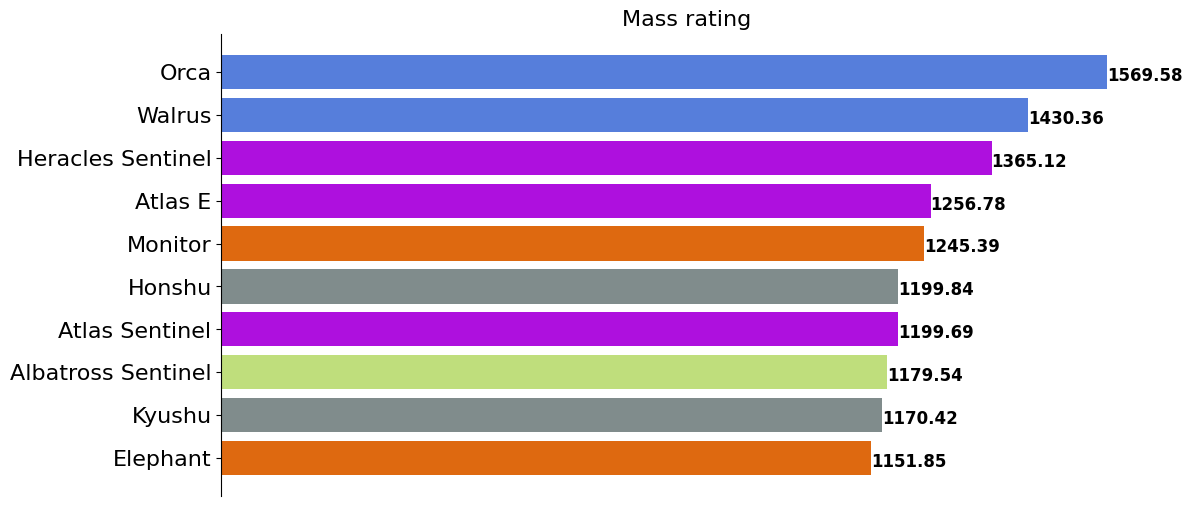

In [134]:
plot_data_1 = all_ships[['name','ship_mass', 'color']].sort_values(by = ['ship_mass'], ascending = False).head(10)

fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot()
ax.barh( plot_data_1['name'][::-1], plot_data_1['ship_mass'][::-1], color = plot_data_1['color'][::-1])
#Оформление
ax.set_title('Mass rating',size=16) 
ax.tick_params(axis='both',labelsize=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.axes.get_xaxis().set_visible(False)
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='12', weight='bold', color='black') 
plt.show()

### Forward drag <a class="anchor" id="id_3b"></a>

In [135]:
plot_data_2 = all_ships[['name','drag_forward','purpose','color']].sort_values(by = ['drag_forward'], ascending = False)
display(plot_data_2.head(10))

,name,drag_forward,purpose,color
147,Stork Sentinel,369.055,auxiliary,#bfde7c
169,Orca,344.677,auxiliary,#567edb
168,Shark,332.118,fight,#567edb
146,Stork Vanguard,324.213,auxiliary,#bfde7c
145,Condor Sentinel,310.771,fight,#bfde7c
141,Atlas E,310.646,auxiliary,#ae10de
140,Atlas Sentinel,299.941,auxiliary,#ae10de
133,Nomad Sentinel,293.991,auxiliary,#2333c2
129,Mammoth Sentinel,292.574,build,#2333c2
144,Condor Vanguard,277.309,fight,#bfde7c


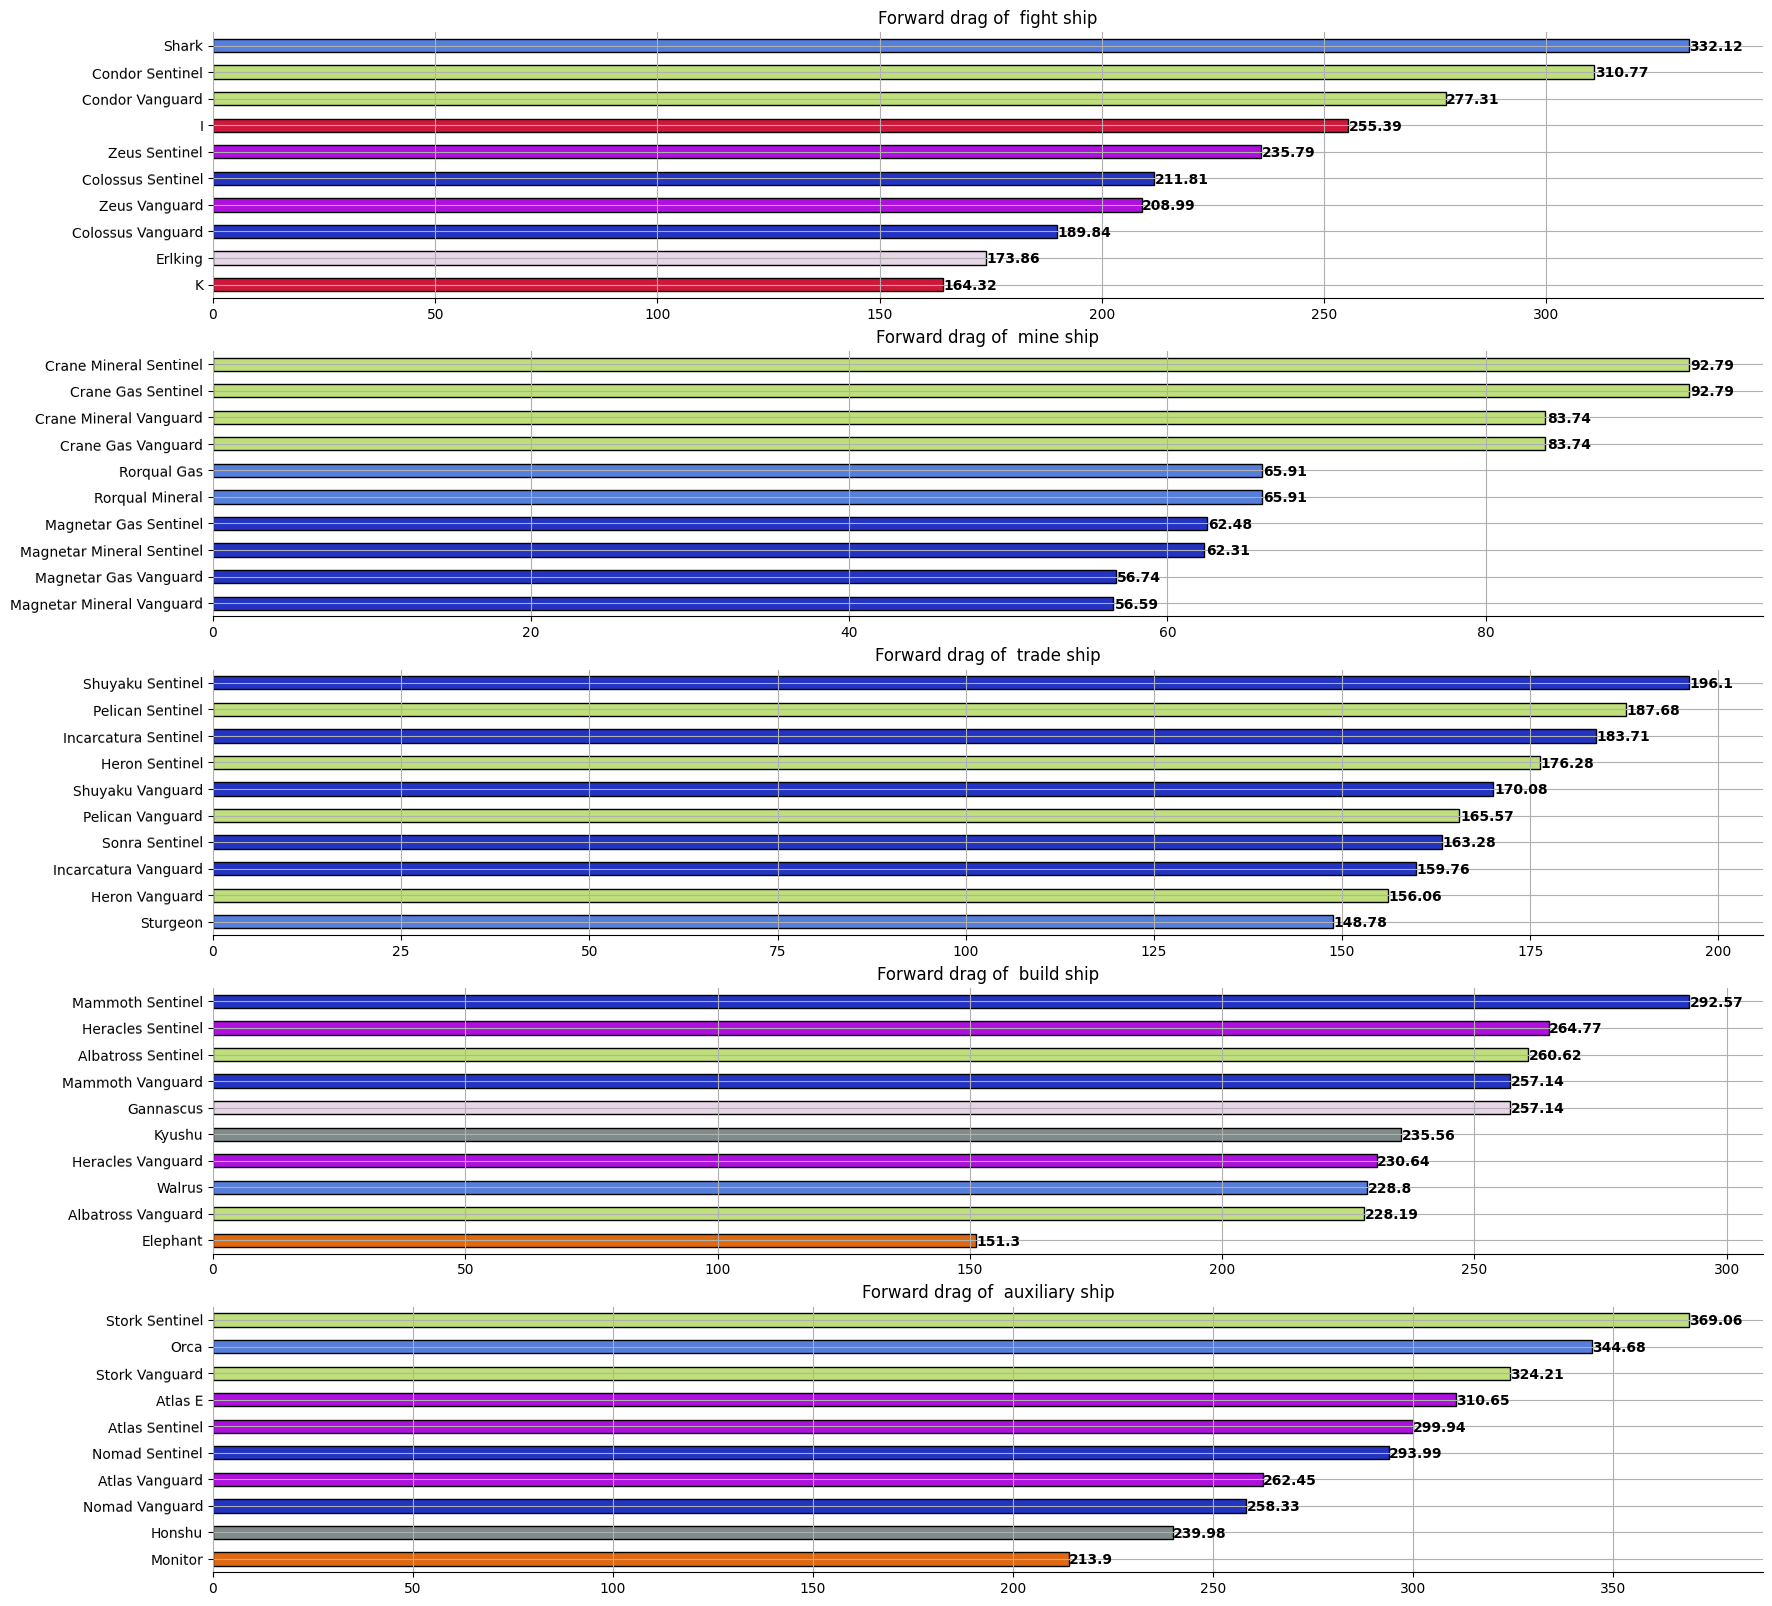

In [136]:
cols = 1 # число колонок под вложенные графики
rows = 5 # число строчек под вложенные графики
count = 0
#Список предназначений кораблей
purposes = ['fight', 'mine', 'trade', 'build', 'auxiliary']
fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for r in range(rows): 
            # временный датафрейм для постройки подграфика
            temp_df =   plot_data_2[plot_data_2['purpose']==purposes[count]].pivot_table(
                index = ['name'],
                values = ['drag_forward','color','purpose'],
                aggfunc = 'first').sort_values(by = ['drag_forward'],ascending = True).tail(10)                      
            axes[r] = temp_df['drag_forward'].plot(  kind='barh',
                                                      ax = axes[r], 
                                                      edgecolor='black', color = temp_df['color'],
                                                       grid=True,
                                                      title = f'Forward drag of  {purposes[count]} ship', xlabel = '', ylabel = '',
                                                      legend=False, rot = 0.45)
            #Убирание рамок вложенных графиков
            axes[r].spines['top'].set_visible(False)
            axes[r].spines['right'].set_visible(False)
            axes[r].spines['left'].set_visible(False)  
            #Нанесение значений            
            rects = axes[r].patches          
            for index in range(len(rects)):
                width = rects[index].get_width()
                t = axes[r].text(width+0.1, rects[index].get_y()+0.2, str(round(width, 2)),
                          fontsize='medium', weight='bold', color='black',va='center',ha='left')
            count+=1
plt.subplots_adjust(hspace=0.2,wspace=0.2)
plt.show()

### Прочность корпуса корабля <a class="anchor" id="id_3c"></a>

In [137]:
plot_data_3 = all_ships[['name','hull','purpose','ship_type','color']]
display(plot_data_3.head(2))
print(all_ships['purpose'].unique())

,name,hull,purpose,ship_type,color
0,Behemoth Vanguard,93000,fight,destroyer,#2333c2
1,Behemoth Sentinel,111000,fight,destroyer,#2333c2


['fight' 'mine' 'trade' 'build' 'auxiliary' 'dismantling' 'salvage']


Признаки dismantling и salvage имеют по одному кораблю, поэтому для этого типа графика их исключу:

In [138]:
purposes = plot_data_3['purpose'].unique() # список назначений корабля
exlude_purposes = ['dismantling', 'salvage']
purposes = [x for x in purposes if x not in exlude_purposes]
print(purposes)

['fight', 'mine', 'trade', 'build', 'auxiliary']


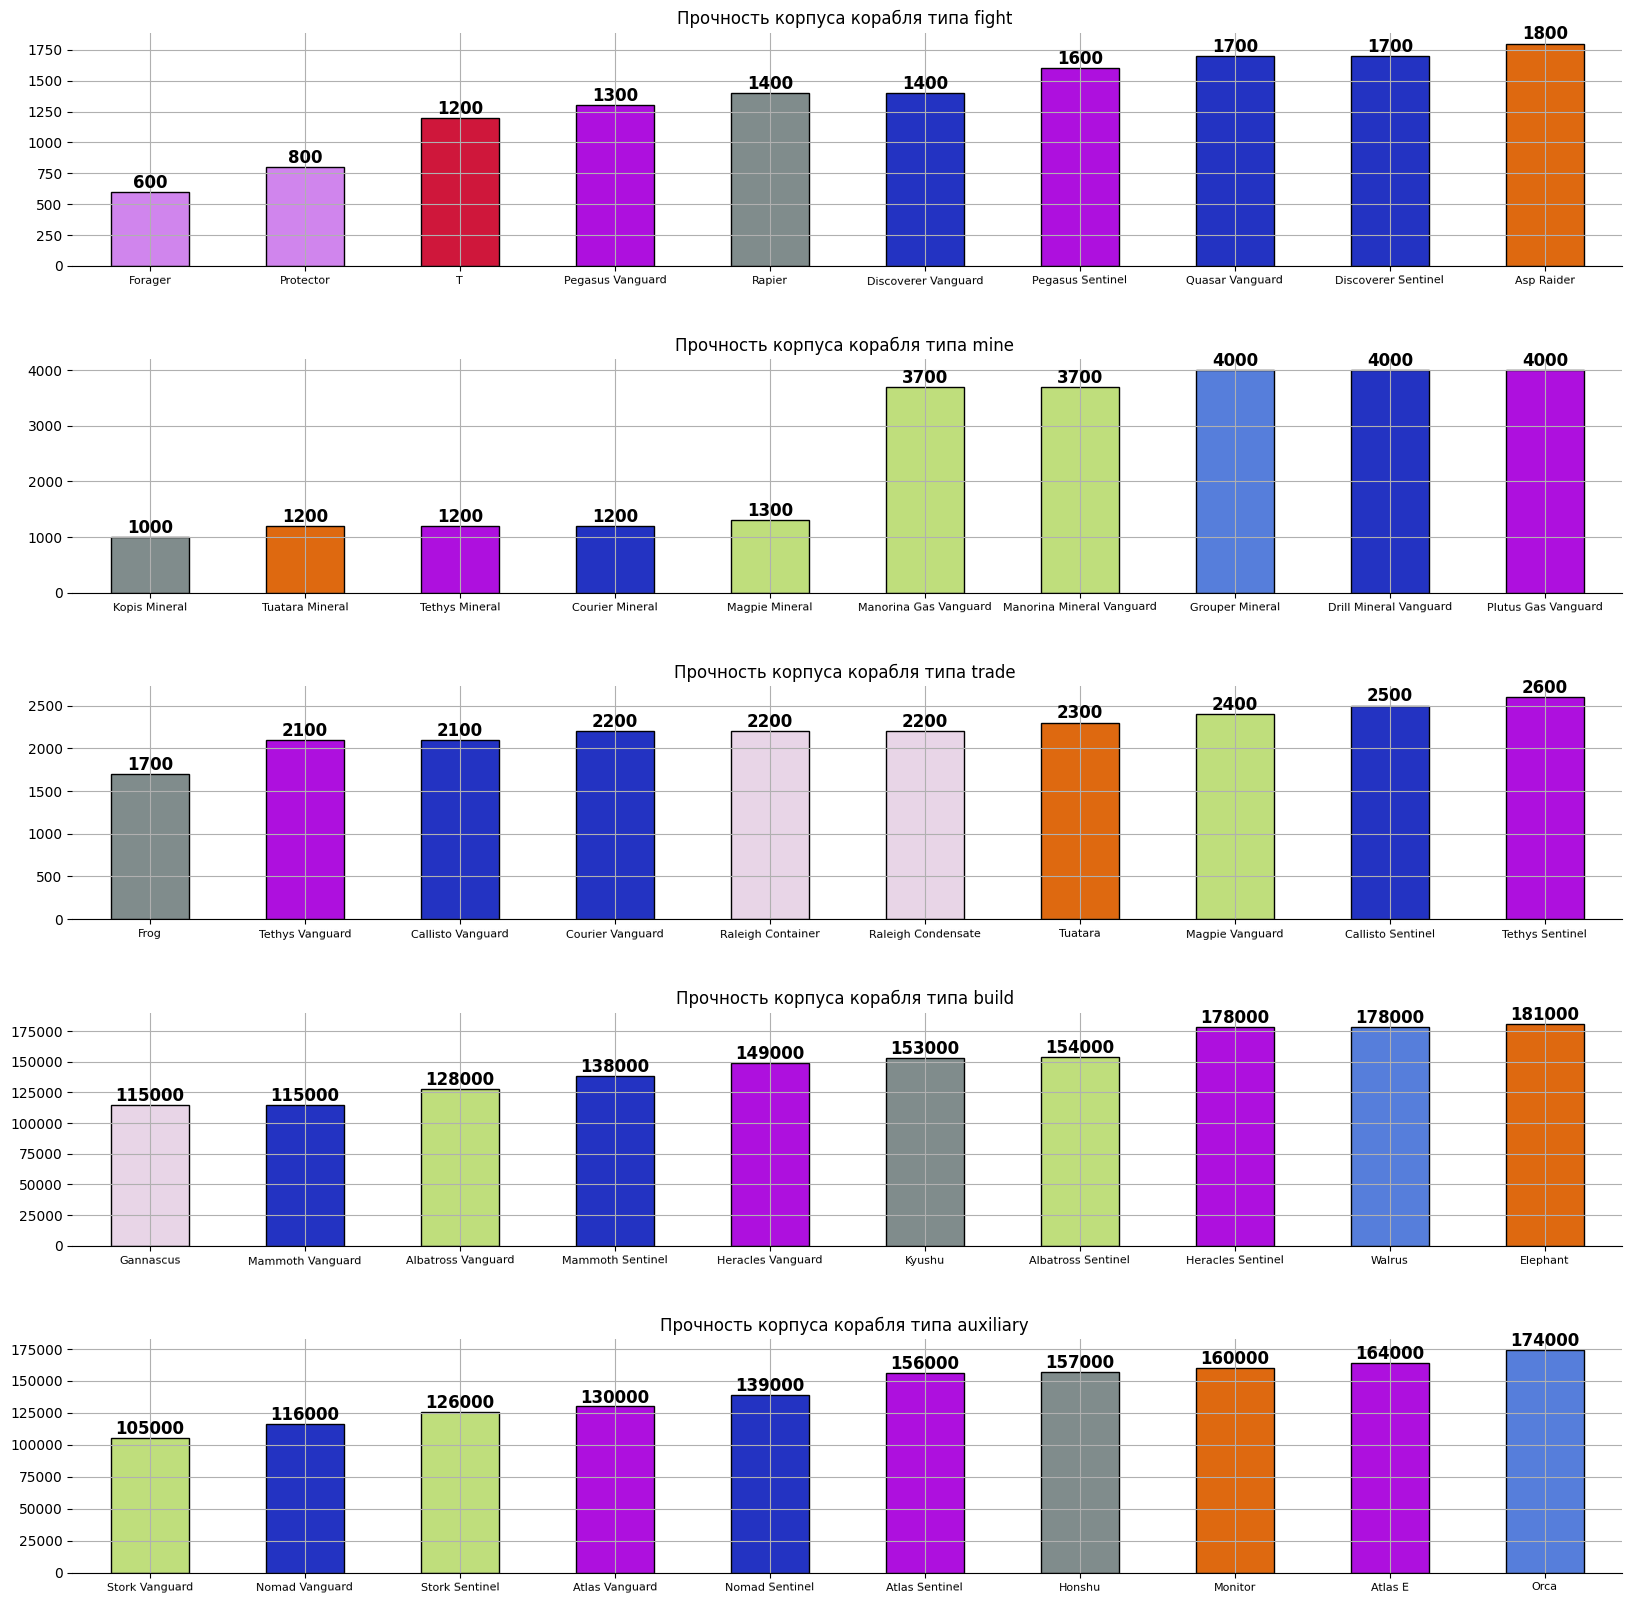

In [139]:
cols = 1 # число колонок под вложенные графики
rows = len(purposes) # число строчек под вложенные графики
count = 0 # counter

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(20,20))
for r in range(rows):                
            temp_df = plot_data_3[plot_data_3['purpose']==purposes[count]].pivot_table(
                  index = ['name'],
                  values = ['hull','purpose','color'],
                  aggfunc ='first' ).sort_values(by = ['hull']).head(10)
            axes[r] = temp_df['hull'].plot(
                kind='bar', ax = axes[r], edgecolor='black',  color = temp_df['color'], grid=True,
                title = f'Прочность корпуса корабля типа {purposes[count]} ', xlabel = '', legend=False, rot = 0.45)
            axes[r].tick_params(axis='x',labelsize=8)
            
            #Убирание рамок вложенных графиков
            axes[r].spines['top'].set_visible(False)
            axes[r].spines['right'].set_visible(False)
            axes[r].spines['left'].set_visible(False)  
            
            #Нанесение значений
            rects = axes[r].patches
            for rect in rects:
                    height = rect.get_height()    
                    axes[r].text(rect.get_x() + rect.get_width() / 2, height + 2, round(height,1),
                          ha="center", va="bottom",weight='bold',size='large',c='black')            
            count+=1
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

#### Прочность корпуса боевых кораблей L класса

In [140]:
purposes = plot_data_3['purpose'].unique() # список назначений корабля

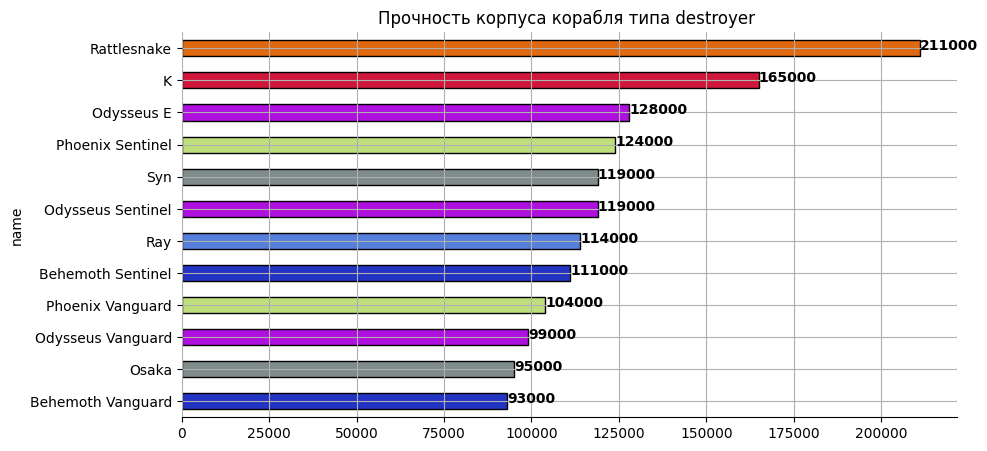

In [141]:
cols = 1 # число колонок под вложенные графики
count = 0 # counter
rows = 1
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = plot_data_3[(plot_data_3['purpose']=='fight')
                                  & (plot_data_3['ship_type']=='destroyer')].pivot_table(
                  index = ['name'],
                  values = ['hull','purpose','color'],
                  aggfunc ='first' ).sort_values(by = ['hull'])
ax = temp_df['hull'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Прочность корпуса корабля типа destroyer ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

#### Прочность корпуса кораблей типа frigate

In [142]:
display(all_ships['ship_type'].unique())

array(['destroyer', 'gunboat', 'scavenger', 'frigate', 'heavyfighter',
       'corvette', 'fighter', 'scout', 'carrier', 'battleship',
       'largeminer', 'miner', 'freighter', 'transporter', 'courier',
       'builder', 'resupplier', 'compactor', 'tug'], dtype=object)

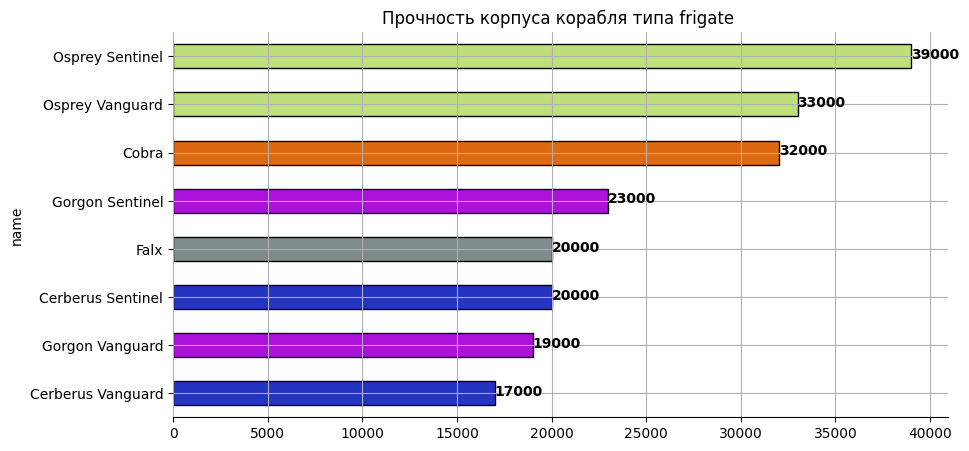

In [143]:
cols = 1 # число колонок под вложенные графики
count = 0 # counter
rows = 1
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = plot_data_3[(plot_data_3['purpose']=='fight')
                                  & (plot_data_3['ship_type']=='frigate')].pivot_table(
                  index = ['name'],
                  values = ['hull','purpose','color'],
                  aggfunc ='first' ).sort_values(by = ['hull'])
ax = temp_df['hull'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Прочность корпуса корабля типа frigate ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

#### Прочность корпуса кораблей типа carrier

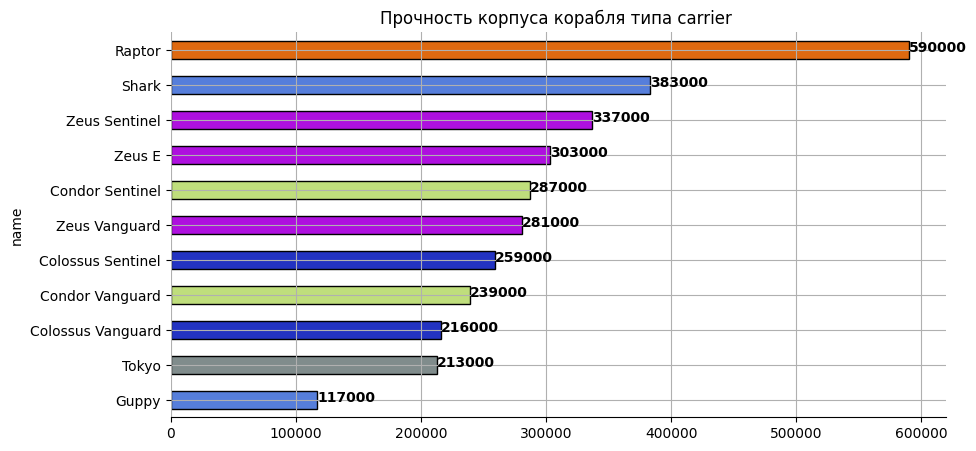

In [144]:
cols = 1 # число колонок под вложенные графики
count = 0 # counter
rows = 1
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = plot_data_3[(plot_data_3['purpose']=='fight')
                                  & (plot_data_3['ship_type']=='carrier')].pivot_table(
                  index = ['name'],
                  values = ['hull','purpose','color'],
                  aggfunc ='first' ).sort_values(by = ['hull'])
ax = temp_df['hull'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Прочность корпуса корабля типа carrier ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

#### Прочность корпуса тяжелых истребителей S класса

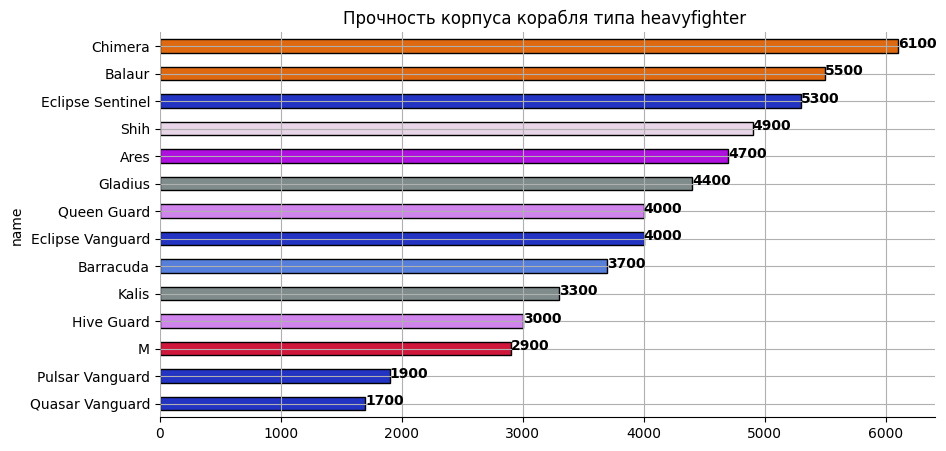

In [145]:
cols = 1 # число колонок под вложенные графики
count = 0 # counter
rows = 1
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = plot_data_3[(plot_data_3['purpose']=='fight')
                                  & (plot_data_3['ship_type']=='heavyfighter')].pivot_table(
                  index = ['name'],
                  values = ['hull','purpose','color'],
                  aggfunc ='first' ).sort_values(by = ['hull'])
ax = temp_df['hull'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Прочность корпуса корабля типа heavyfighter ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

##### XL carriers

In [146]:
display(shield_data.query('type=="XL"')[['name','maker','shield_value']].sort_values(by=['shield_value'], ascending = False))

,name,maker,shield_value
64,TER XL Shield Generator Mk2,terran,161988
53,BOR XL Shield Generator Mk2,boron,159937
42,Erlking XL Shield Generator,argon,158600
25,TEL XL Shield Generator Mk1,teladi,142429
63,TER XL Shield Generator Mk1,terran,135955
52,BOR XL Shield Generator Mk1,boron,133766
7,ARG XL Shield Generator Mk1,argon,129481
32,XEN XL Shield Generator Mk1,xenon,123007
17,PAR XL Shield Generator Mk1,paranid,116532
40,SPL XL Shield Generator Mk1,split,110058


In [147]:
xl_carriers = (accesible_ships.query('(ship_class=="ship_xl") & (ship_type=="carrier")')
               [['name','race', 'hull','primary_shield_slots', 'aggregate_defence', 'color']].reset_index(drop=True)
)
display(xl_carriers)

,name,race,hull,primary_shield_slots,aggregate_defence,color
0,Colossus Vanguard,argon,216000,3,701964,#2333c2
1,Colossus Sentinel,argon,259000,3,744964,#2333c2
2,Zeus Vanguard,paranid,281000,2,604976,#ae10de
3,Zeus Sentinel,paranid,337000,2,660976,#ae10de
4,Zeus E,paranid,303000,2,626976,#ae10de
5,Condor Vanguard,teladi,239000,2,562976,#bfde7c
6,Condor Sentinel,teladi,287000,2,610976,#bfde7c
7,Shark,boron,383000,5,1182685,#567edb
8,Tokyo,terran,213000,3,698964,#808c8c
9,Raptor,split,590000,1,751988,#de6910


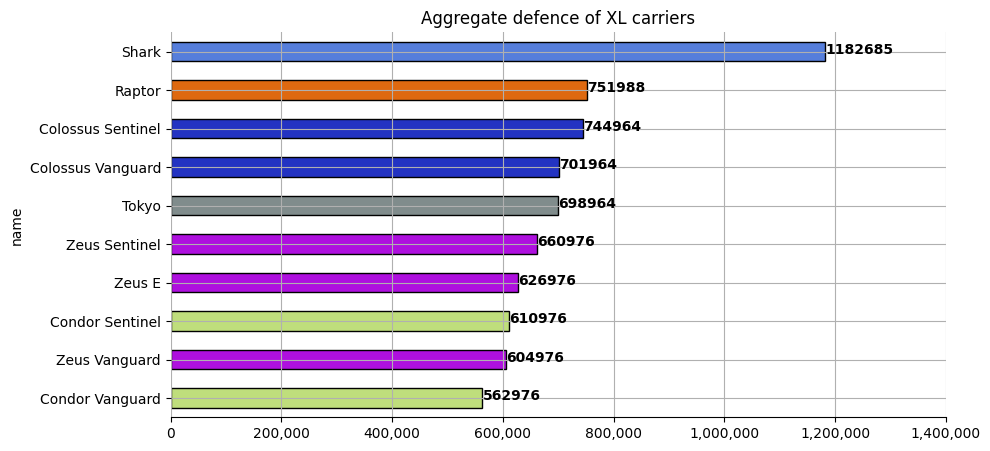

In [148]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = xl_carriers.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Aggregate defence of XL carriers', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
#изменение формата значений на оси x
label_format = '{:,.0f}'
ticks_loc = ax.get_xticks().tolist()
ax.set_xticks(ax.get_xticks().tolist()) # fixing xticks with "set_xticks" FixedLocator error
ax.set_xticklabels([label_format.format(x) for x in ticks_loc])
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

In [149]:
shark_vs_asgard = (accesible_ships.query('(name=="Shark") | (name=="Asgard")')
               [['name','race', 'hull','primary_shield_slots', 'aggregate_defence','color']].reset_index(drop=True)
)
display(shark_vs_asgard)

,name,race,hull,primary_shield_slots,aggregate_defence,color
0,Shark,boron,383000,5,1182685,#567edb
1,Asgard,terran,275000,4,922952,#808c8c


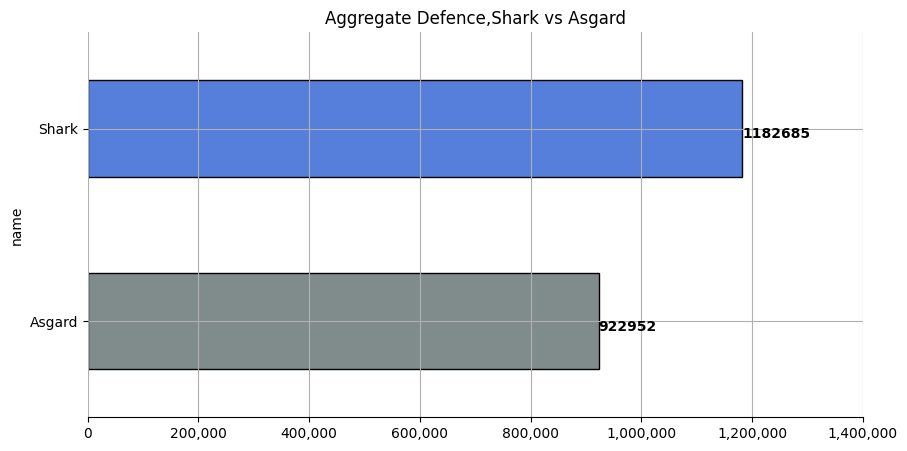

In [150]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = shark_vs_asgard.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Aggregate Defence,Shark vs Asgard', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False) 
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
#Изменение формата значений на оси x
label_format = '{:,.0f}'
ticks_loc = ax.get_xticks().tolist()
ax.set_xticks(ax.get_xticks().tolist()) # fixing xticks with "set_xticks" FixedLocator error
ax.set_xticklabels([label_format.format(x) for x in ticks_loc])
plt.show()

##### L destroyers

Статистика по L щитам:

In [151]:
display(shield_data.query('type=="L"')[['name','maker','shield_value']].sort_values(by=['shield_value'], ascending = False).head())

,name,maker,shield_value
56,TER L Shield Generator Mk3,terran,69424
45,BOR L Shield Generator Mk3,boron,68399
19,TEL L Shield Generator Mk2,teladi,50911
55,TER L Shield Generator Mk2,terran,48597
44,BOR L Shield Generator Mk2,boron,47879


In [152]:
destroyers_df = (accesible_ships.query('(ship_class=="ship_l") & (ship_type=="destroyer")')
               [['name','race', 'hull','primary_shield_slots', 'aggregate_defence','max_speed', 'color']].reset_index(drop=True)
)
display(destroyers_df)

,name,race,hull,primary_shield_slots,aggregate_defence,max_speed,color
0,Behemoth Vanguard,argon,93000,3,301272,172,#2333c2
1,Behemoth Sentinel,argon,111000,3,319272,157,#2333c2
2,Odysseus Vanguard,paranid,99000,2,237848,222,#ae10de
3,Odysseus Sentinel,paranid,119000,2,257848,201,#ae10de
4,Odysseus E,paranid,128000,2,266848,247,#ae10de
5,Phoenix Vanguard,teladi,104000,3,312272,185,#bfde7c
6,Phoenix Sentinel,teladi,124000,3,332272,167,#bfde7c
7,Ray,boron,114000,4,387596,124,#567edb
8,Syn,terran,119000,3,327272,117,#808c8c
9,Osaka,terran,95000,3,303272,141,#808c8c


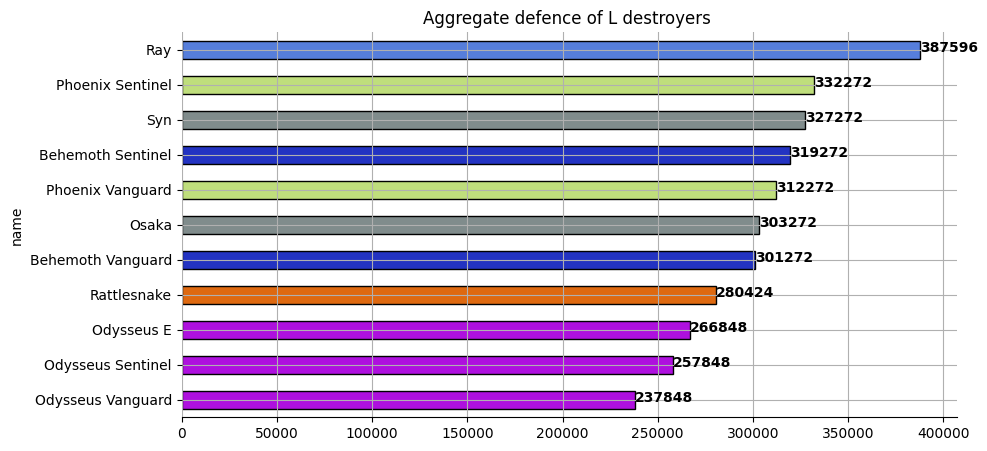

In [153]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = destroyers_df.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Aggregate defence of L destroyers ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

##### M frigates

In [154]:
frigates_df = (accesible_ships.query('(ship_class=="ship_m") & (ship_type=="frigate")')
               [['name','race', 'hull','primary_shield_slots', 'aggregate_defence', 'max_speed', 'color']].reset_index(drop=True)
)
display(frigates_df)

,name,race,hull,primary_shield_slots,aggregate_defence,max_speed,color
0,Cerberus Vanguard,argon,17000,3,44597,440,#2333c2
1,Cerberus Sentinel,argon,20000,3,47597,381,#2333c2
2,Gorgon Vanguard,paranid,19000,3,46597,587,#ae10de
3,Gorgon Sentinel,paranid,23000,3,50597,506,#ae10de
4,Osprey Vanguard,teladi,33000,3,60597,226,#bfde7c
5,Osprey Sentinel,teladi,39000,3,66597,192,#bfde7c
6,Falx,terran,20000,2,38398,481,#808c8c
7,Cobra,split,32000,2,50398,705,#de6910


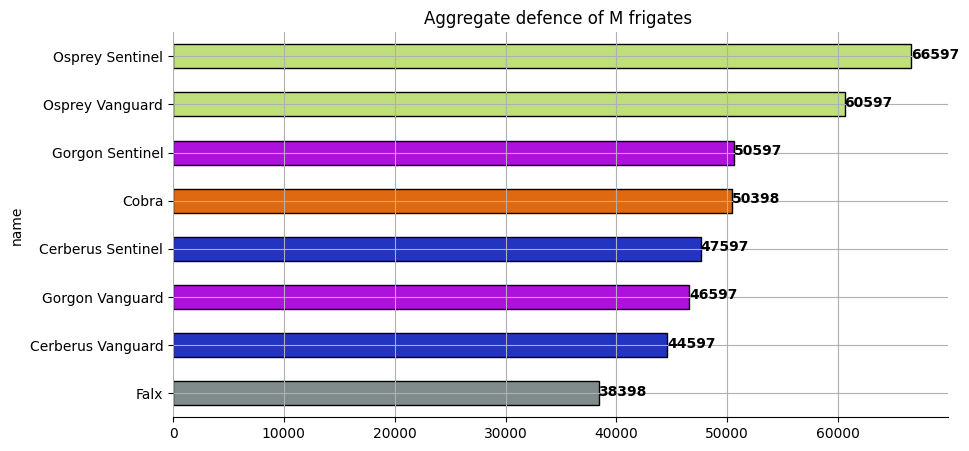

In [155]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = frigates_df.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Aggregate defence of M frigates ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

##### M gunboats

Создание выборки кораблей:

In [156]:
gunboats_df = (accesible_ships.query('(ship_class=="ship_m") & (ship_type=="gunboat")')
               [['name','race', 'hull','primary_shield_slots', 'aggregate_defence', 'max_speed','color']].reset_index(drop=True)
)
display(gunboats_df)

,name,race,hull,primary_shield_slots,aggregate_defence,max_speed,color
0,Minotaur Vanguard,argon,12000,2,30398,371,#2333c2
1,Minotaur Sentinel,argon,14000,2,32398,322,#2333c2
2,Peregrine Vanguard,teladi,12000,3,39597,463,#bfde7c
3,Peregrine Sentinel,teladi,14000,3,41597,403,#bfde7c
4,Thresher,boron,10900,2,28654,461,#567edb
5,Jian,terran,13000,2,31398,443,#808c8c
6,Viper,split,25000,1,34199,663,#de6910


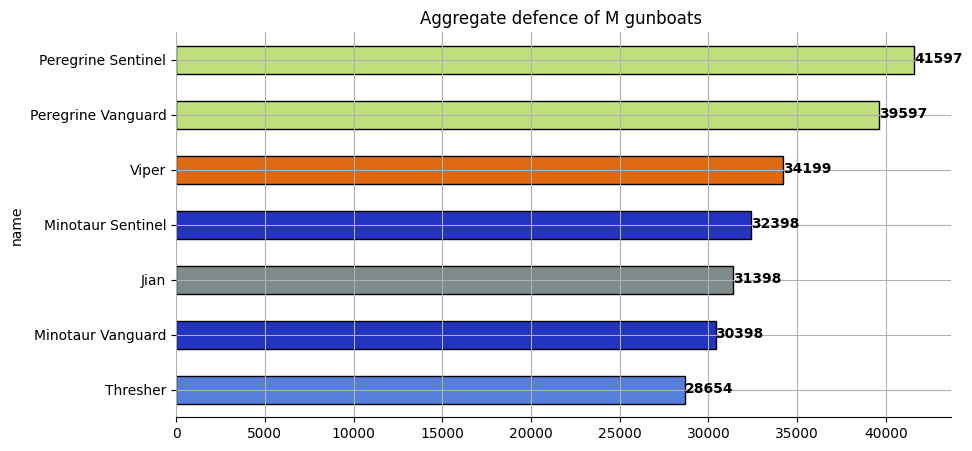

In [157]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = gunboats_df.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Aggregate defence of M gunboats ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

##### Heavyfighters

In [158]:
heavyfighters_df = (accesible_ships.query('(ship_class=="ship_s") & (ship_type=="heavyfighter")')
               [['name','race', 'hull','primary_shield_slots', 'aggregate_defence','max_speed', 'color']].reset_index(drop=True)
)
display(heavyfighters_df)

,name,race,hull,primary_shield_slots,aggregate_defence,max_speed,color
0,Pulsar Vanguard,argon,1900,1,3452,415,#2333c2
1,Quasar Vanguard,argon,1700,1,3252,341,#2333c2
2,Eclipse Sentinel,argon,5300,2,8404,288,#2333c2
3,Eclipse Vanguard,argon,4000,2,7104,321,#2333c2
4,Ares,paranid,4700,3,9356,290,#ae10de
5,Barracuda,boron,3700,3,8065,167,#567edb
6,Shih,pirate,4900,3,9556,359,#e8d5e7
7,Kalis,terran,3300,4,9508,331,#808c8c
8,Gladius,terran,4400,2,7504,301,#808c8c
9,Chimera,split,6100,1,7652,503,#de6910


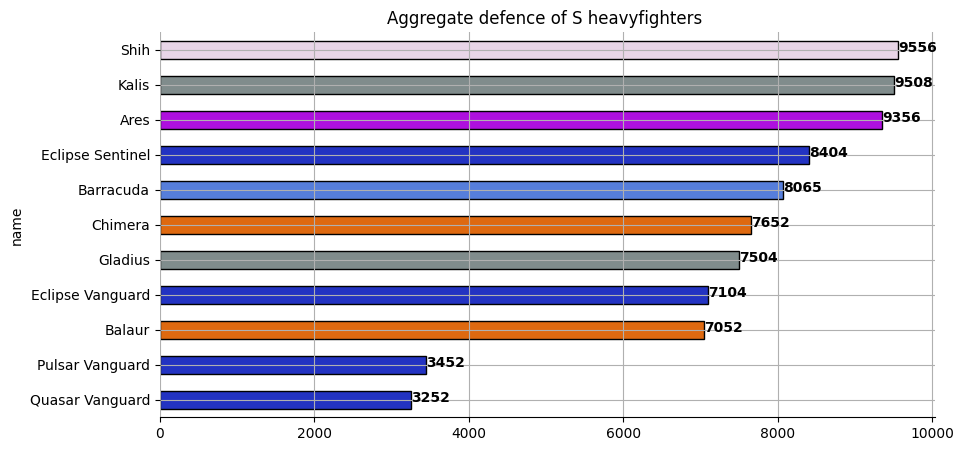

In [159]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = heavyfighters_df.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Aggregate defence of S heavyfighters ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, str(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

##### S fighters

In [160]:
fighters_df = (accesible_ships.query('(ship_class=="ship_s") & (ship_type=="fighter")')
               [['name','race', 'hull','primary_shield_slots', 'aggregate_defence','max_speed', 'color']].reset_index(drop=True)
)
display(fighters_df.head())

,name,race,hull,primary_shield_slots,aggregate_defence,max_speed,color
0,Nova Vanguard,argon,3100,1,4652,416,#2333c2
1,Nova Sentinel,argon,3800,1,5352,397,#2333c2
2,Elite Vanguard,argon,1800,1,3352,363,#2333c2
3,Elite Sentinel,argon,2200,1,3752,335,#2333c2
4,Perseus Vanguard,paranid,3700,1,5252,599,#ae10de


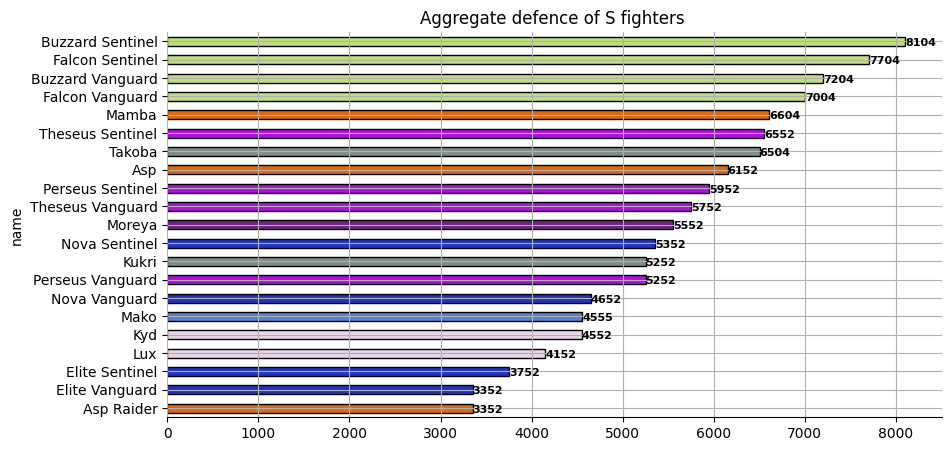

In [161]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = fighters_df.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Aggregate defence of S fighters ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y(), str(round(width, 2)),fontsize='8', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

##### Составная диаграмма

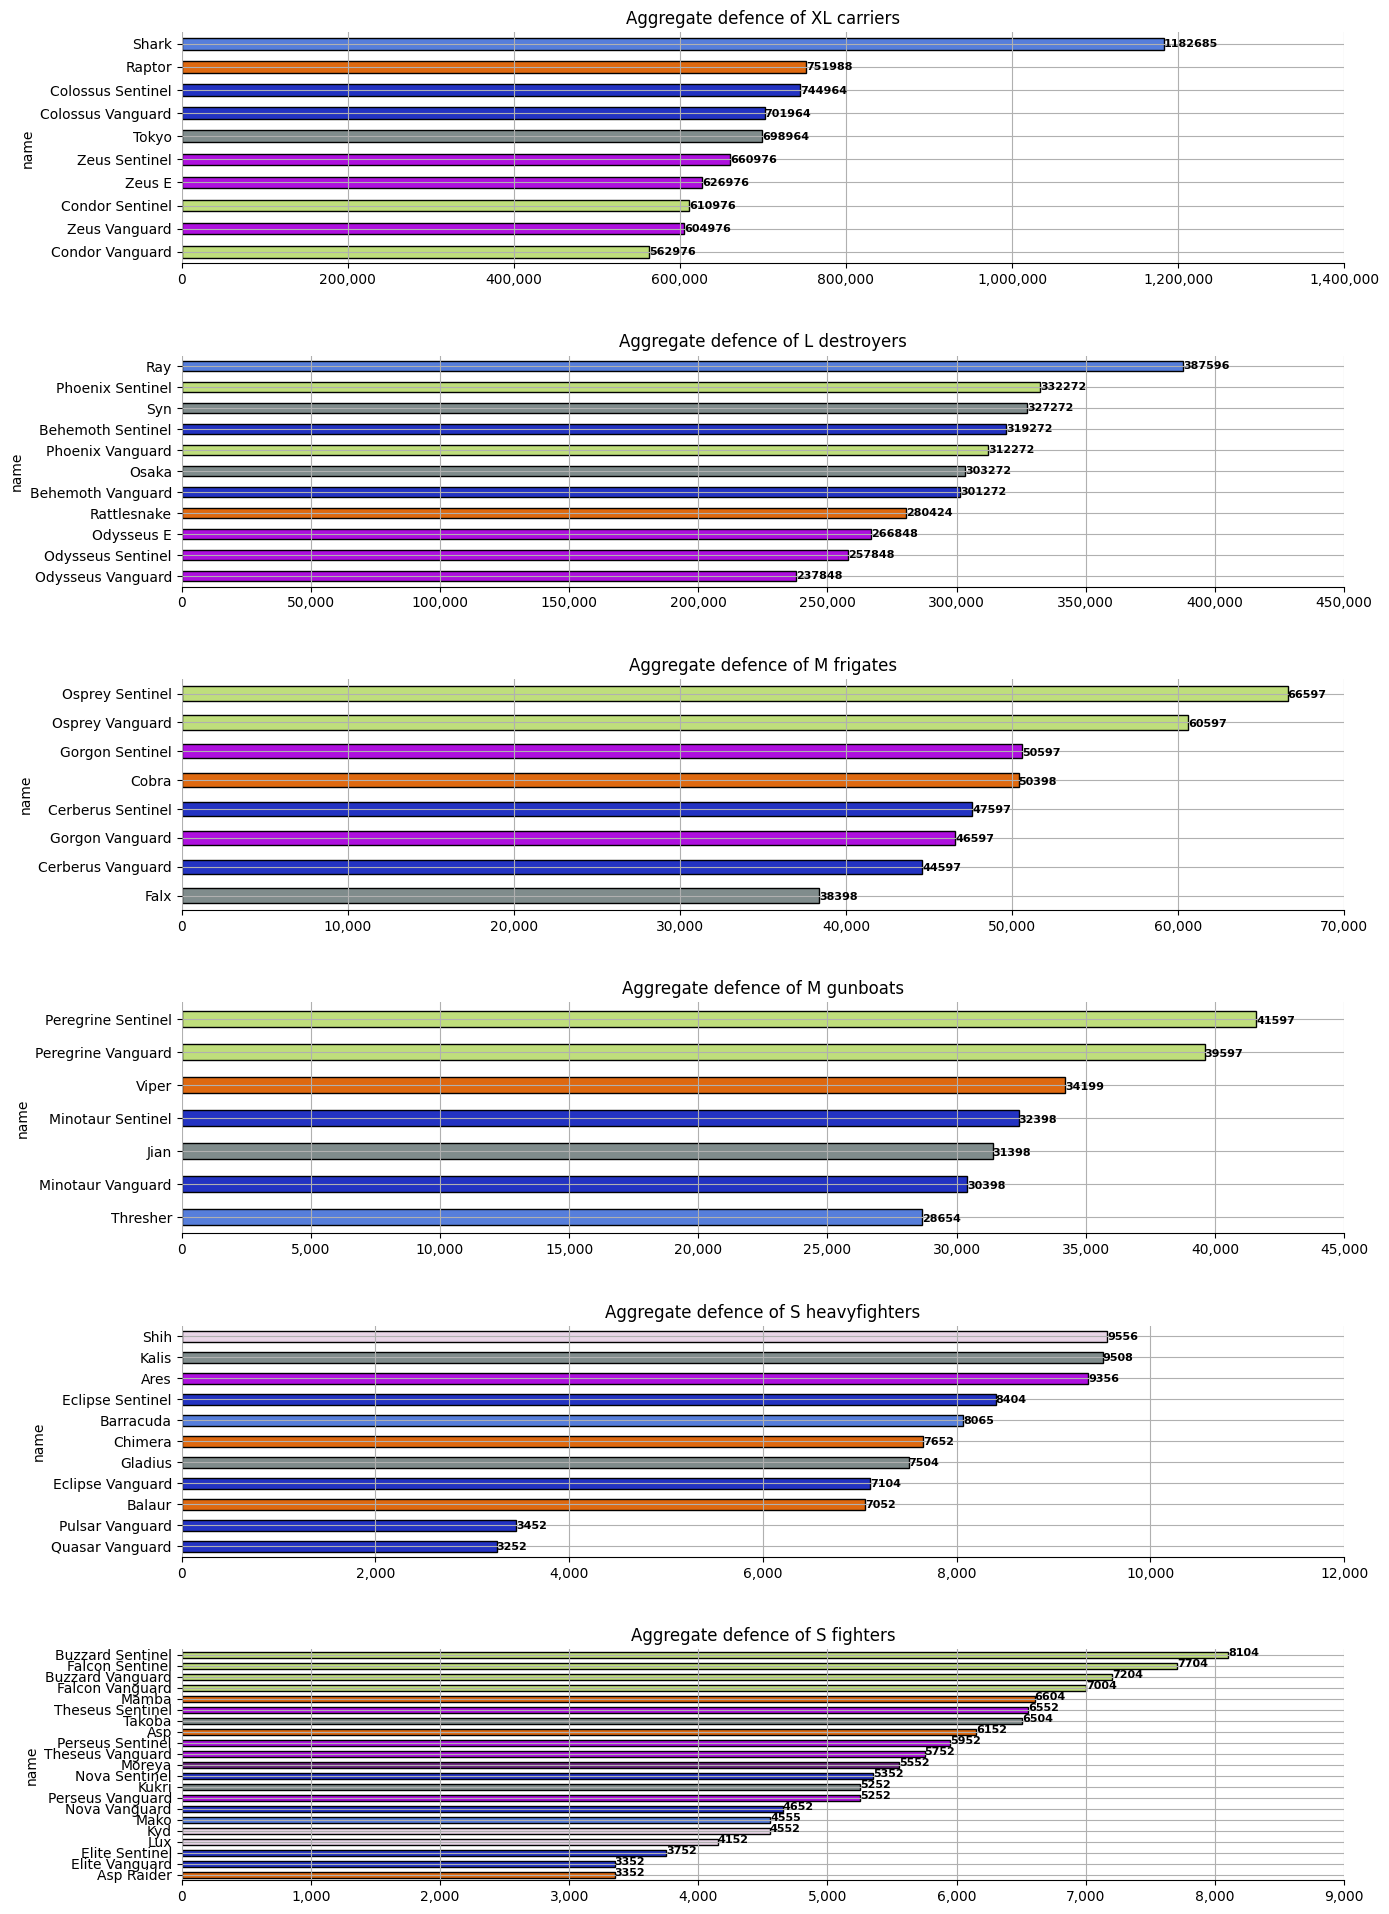

In [162]:
dfs = [xl_carriers,destroyers_df,frigates_df,gunboats_df,heavyfighters_df,fighters_df]
titles = ['Aggregate defence of XL carriers', 'Aggregate defence of L destroyers', 'Aggregate defence of M frigates',
          'Aggregate defence of M gunboats', 'Aggregate defence of S heavyfighters', 'Aggregate defence of S fighters']
nrows = len(dfs)
ncols = 1
count = 0
for df in dfs:
    temp_df = df.pivot_table(
                  index = ['name'],
                  values = ['aggregate_defence','color'],
                  aggfunc ='first' ).sort_values(by = ['aggregate_defence'])
    ax = temp_df['aggregate_defence'].plot(
                kind='barh', ax = plt.subplot(nrows,ncols,count+1), figsize=(15,24), edgecolor='black',  color =temp_df['color'] , grid=True,
                title = titles[count], xlabel = '', legend=False)
     #Убирание рамок вложенных графиков
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)  
    #Надписи
    rects = ax.patches
    for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.1, int(round(width, 2)),fontsize='8', weight='bold', color='black')
    #Изменение формата значений на оси x
    label_format = '{:,.0f}'
    ticks_loc = ax.get_xticks().tolist()
    ax.set_xticks(ax.get_xticks().tolist()) # fixing xticks with "set_xticks" FixedLocator error
    ax.set_xticklabels([label_format.format(x) for x in ticks_loc])
    count +=1
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()
 

In [163]:
all_ships.query('(ship_class=="ship_xl") & (ship_type=="battleship")')

,component,filename,ship_class,explosiondamage_shield,explosiondamage_value,storage_missile,storage_unit,hull,secrecy_level,purpose,people_capacity,ship_mass,inertia_pitch,inertia_roll,inertia_yaw,drag_forward,drag_reverse,drag_horizontal,drag_vertical,drag_pitch,drag_yaw,drag_roll,ship_type,name,name_id,primary_shield_slots,turret_shield_slots,l_turret_slots,m_turret_slots,engines_slots,race,color
148,ship_xen_xl_carrier_01,ship_xen_xl_carrier_01_a_macro,ship_xl,1500,7500,0,0,340000,2,fight,0,876.951,958.525,958.525,766.820,255.390,1021.561,138.309,138.309,787.851,787.851,787.851,battleship,I,70601,5,50,20,20,2,xenons,#cf173b
179,ship_pir_xl_battleship_01,ship_pir_xl_battleship_01_a_macro,ship_xl,1500,7500,300,20,500000,0,fight,328,295.441,280.021,280.021,224.017,173.860,695.441,211.606,211.606,683.179,683.179,683.179,battleship,Erlking,121101,1,13,5,17,3,pirate,#e8d5e7
203,ship_atf_xl_battleship_01,ship_atf_xl_battleship_01_a_macro,ship_xl,1500,7500,1160,10,275000,3,fight,360,487.388,485.311,485.311,388.249,133.108,532.433,259.232,259.232,717.730,717.730,717.730,battleship,Asgard,66601,4,42,16,6,1,terran,#808c8c
226,ship_spl_xl_battleship_01,ship_spl_xl_battleship_01_a_macro,ship_xl,1500,7500,480,20,230000,2,fight,65,353.740,523.732,523.732,418.986,146.979,587.917,233.555,233.555,693.673,693.673,693.673,battleship,Python,40201,1,22,8,18,4,split,#de6910


#### Скорость кораблей

Закон Ньютона   
F = mass*acceleration     
Acceleration = Engine Thrust/Ship Mass * Number_OF_Engines   
Max Speed = Engine Thrust/Ship Directional Drag  * Number_Of_Engines

Сравнение скорости L дестроеров

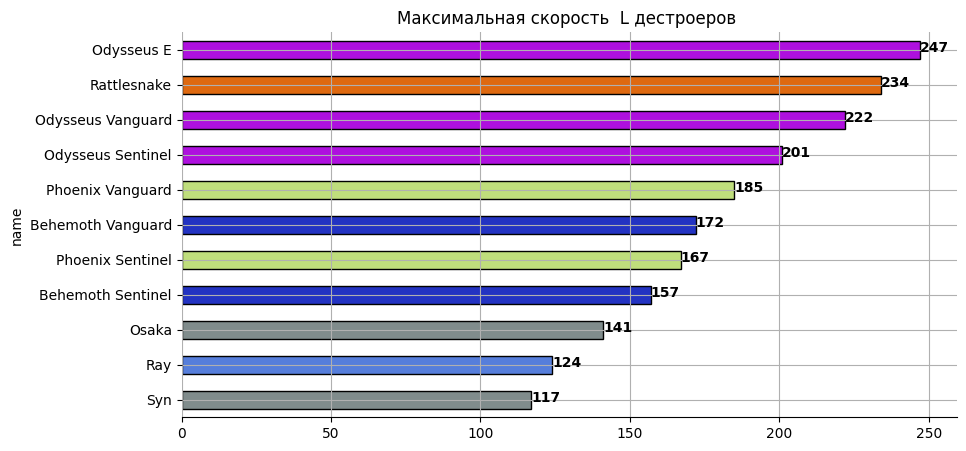

In [164]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = destroyers_df.pivot_table(
                  index = ['name'],
                  values = ['max_speed','color'],
                  aggfunc ='first' ).sort_values(by = ['max_speed'])
ax = temp_df['max_speed'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Максимальная скорость  L дестроеров ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

Максимальная скорость М фрегатов

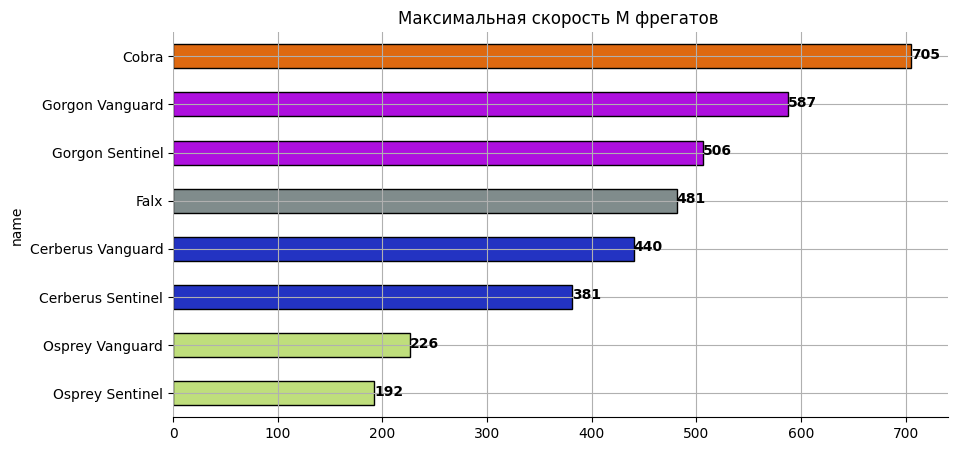

In [165]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = frigates_df.pivot_table(
                  index = ['name'],
                  values = ['max_speed','color'],
                  aggfunc ='first' ).sort_values(by = ['max_speed'])
ax = temp_df['max_speed'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Максимальная скорость М фрегатов ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

Максимальная скорость канонерок.

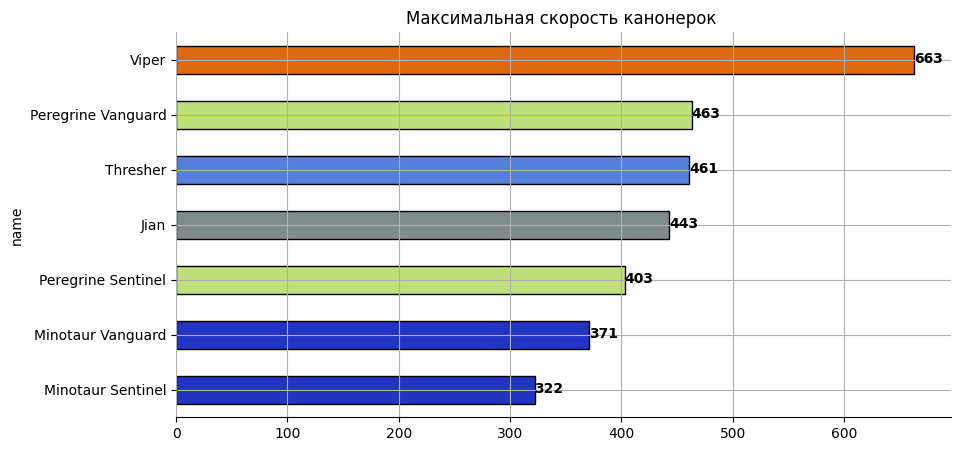

In [166]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = gunboats_df.pivot_table(
                  index = ['name'],
                  values = ['max_speed','color'],
                  aggfunc ='first' ).sort_values(by = ['max_speed'])
ax = temp_df['max_speed'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Максимальная скорость канонерок ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

Максимальная скорость тяжелых истребителей

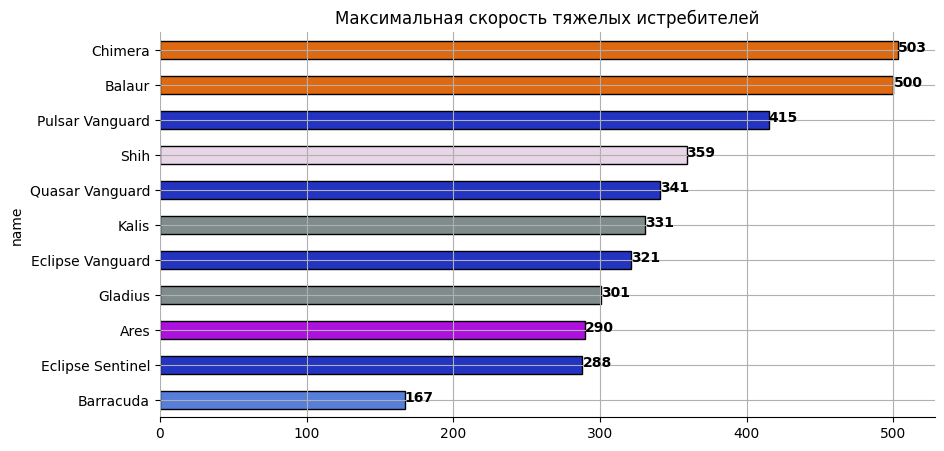

In [167]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = heavyfighters_df.pivot_table(
                  index = ['name'],
                  values = ['max_speed','color'],
                  aggfunc ='first' ).sort_values(by = ['max_speed'])
ax = temp_df['max_speed'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Максимальная скорость тяжелых истребителей', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()

Максимальная скорость S истребителей

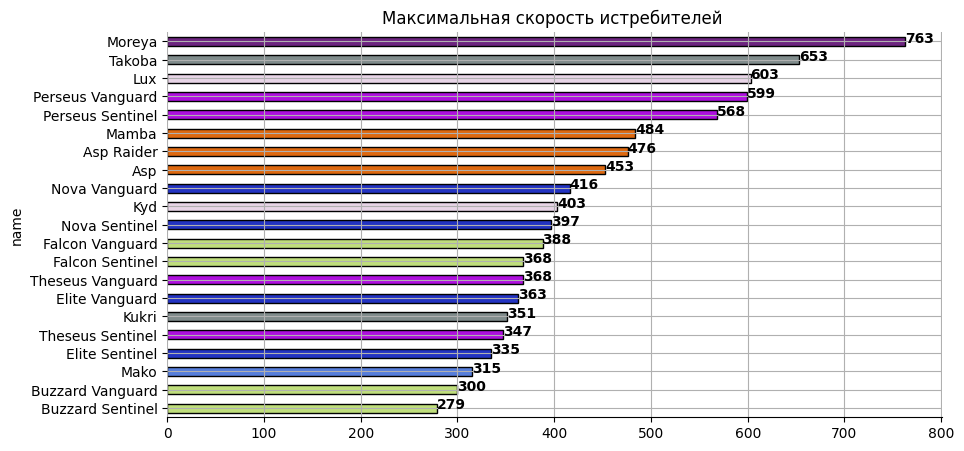

In [168]:
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot()
temp_df = fighters_df.pivot_table(
                  index = ['name'],
                  values = ['max_speed','color'],
                  aggfunc ='first' ).sort_values(by = ['max_speed'])
ax = temp_df['max_speed'].plot(
                kind='barh', ax = ax, edgecolor='black',  color =temp_df['color'] , grid=True,
                title = f'Максимальная скорость истребителей ', xlabel = '', legend=False)
            
            #Убирание рамок вложенных графиков
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)  
#Надписи
rects = ax.patches
for bar in rects:   
        width = bar.get_width()    
        ax.text(width, bar.get_y()+0.2, int(round(width, 2)),fontsize='10', weight='bold', color='black') 
plt.subplots_adjust(hspace=0.4, wspace=0.3)
plt.show()